In [2]:
import psycopg2
from psycopg2.extras import execute_values
import pandas as pd

In [ ]:

# Đọc dữ liệu từ file CSV
file_path = '../data/raw/KAG_conversion_data.csv'
df = pd.read_csv(file_path)

# Hàm tách dữ liệu thành các bảng
def prepare_star_schema(df):
    # Dimension: Campaign
    dim_campaign = df[['fb_campaign_id']].drop_duplicates()
    
    # Dimension: Demographics (Thêm cột Spent vào dim_demographics)
    dim_demographics = df[['age', 'gender', 'Spent']].drop_duplicates()
    dim_demographics['demographic_id'] = dim_demographics.index + 1  # Tạo ID duy nhất
    
    # Dimension: Interest
    dim_interest = df[['interest']].drop_duplicates()
    dim_interest['interest_id'] = dim_interest.index + 1  # Tạo ID duy nhất
    
    # Fact Table: Ads Metrics
    fact_ads_metrics = df[['ad_id', 'fb_campaign_id', 'age', 'gender', 'interest', 
                           'Impressions', 'Clicks', 'Total_Conversion', 'Approved_Conversion', 'Spent']]

    # Merge với dimension
    fact_ads_metrics = fact_ads_metrics.merge(dim_demographics[['age', 'gender', 'Spent', 'demographic_id']], on=['age', 'gender', 'Spent'], how='left')
    fact_ads_metrics = fact_ads_metrics.merge(dim_interest, on='interest', how='left')
    fact_ads_metrics = fact_ads_metrics.merge(dim_campaign, on='fb_campaign_id', how='left')
    
    # Tạo bảng fact với cột đã được chuẩn hóa
    fact_ads_metrics = fact_ads_metrics[[ 
        'ad_id', 'fb_campaign_id', 'demographic_id', 'interest_id', 
        'Impressions', 'Clicks', 'Total_Conversion', 'Approved_Conversion'
    ]]
    
    return dim_campaign, dim_demographics, dim_interest, fact_ads_metrics

# Tách dữ liệu thành các bảng
dim_campaign, dim_demographics, dim_interest, fact_ads_metrics = prepare_star_schema(df)

# Chuyển đổi dữ liệu thành Python native types
dim_campaign = dim_campaign.astype(object)
dim_demographics = dim_demographics.astype(object)
dim_interest = dim_interest.astype(object)
fact_ads_metrics = fact_ads_metrics.astype(object)

# Hàm tạo bảng nếu chưa tồn tại
def create_table_if_not_exists(df, table_name, conn):
    # Xử lý cột Spent khi tạo bảng dim_demographics
    cols = ', '.join([f"{col} TEXT" if col != 'Spent' else f"{col} FLOAT" for col in df.columns])  # Thêm FLOAT cho cột Spent
    create_table_query = f"CREATE TABLE IF NOT EXISTS {table_name} ({cols});"
    cur = conn.cursor()
    cur.execute(create_table_query)
    conn.commit()

    if table_name == "dim_campaign":
        cur.execute("""
            ALTER TABLE dim_campaign
            ADD CONSTRAINT dim_campaign_pkey PRIMARY KEY (fb_campaign_id);
        """)
    elif table_name == "dim_demographics":
        cur.execute("""
            ALTER TABLE dim_demographics
            ADD CONSTRAINT dim_demographics_pkey PRIMARY KEY (demographic_id);
        """)
    elif table_name == "dim_interest":
        cur.execute("""
            ALTER TABLE dim_interest
            ADD CONSTRAINT dim_interest_pkey PRIMARY KEY (interest_id);
        """)
    elif table_name == "fact_ads_metrics":
        cur.execute("""
            ALTER TABLE fact_ads_metrics
            ADD CONSTRAINT fact_ads_metrics_pkey PRIMARY KEY (ad_id);
        """)

    conn.commit()

# Hàm thêm khóa ngoại vào bảng
def add_foreign_keys(conn):
    try:
        cur = conn.cursor()
        # Thêm khóa ngoại cho dim_demographics và fact_ads_metrics
        cur.execute("""
            ALTER TABLE fact_ads_metrics
            ADD CONSTRAINT fk_campaign
            FOREIGN KEY (fb_campaign_id)
            REFERENCES dim_campaign(fb_campaign_id);
        """)
        cur.execute("""
            ALTER TABLE fact_ads_metrics
            ADD CONSTRAINT fk_demographics
            FOREIGN KEY (demographic_id)
            REFERENCES dim_demographics(demographic_id);
        """)
        cur.execute("""
            ALTER TABLE fact_ads_metrics
            ADD CONSTRAINT fk_interest
            FOREIGN KEY (interest_id)
            REFERENCES dim_interest(interest_id);
        """)
        conn.commit()
        print("Đã thêm các khóa ngoại thành công.")
    except Exception as e:
        print(f"Lỗi khi thêm khóa ngoại: {e}")
        conn.rollback()

# Hàm upload DataFrame vào PostgreSQL
def upload_to_postgresql(df, table_name, conn):
    """
    Upload DataFrame vào PostgreSQL.
    """
    try:
        create_table_if_not_exists(df, table_name, conn)  # Tạo bảng nếu chưa tồn tại
        # Chuyển DataFrame thành danh sách tuples để insert
        tuples = [tuple(x) for x in df.to_numpy()]
        cols = ','.join(list(df.columns))
        query = f"INSERT INTO {table_name}({cols}) VALUES %s"
        
        cur = conn.cursor()
        execute_values(cur, query, tuples)
        conn.commit()
        print(f"Đã upload bảng {table_name} thành công.")
    except Exception as e:
        print(f"Lỗi khi upload bảng {table_name}: {e}")
        conn.rollback()

# Main function
def main():
    # Kết nối PostgreSQL
    conn = psycopg2.connect(
        ""
    )

    try:
        # Upload các bảng vào PostgreSQL
        upload_to_postgresql(dim_campaign, 'dim_campaign', conn)
        upload_to_postgresql(dim_demographics, 'dim_demographics', conn)
        upload_to_postgresql(dim_interest, 'dim_interest', conn)
        upload_to_postgresql(fact_ads_metrics, 'fact_ads_metrics', conn)
        
        # Thêm khóa ngoại sau khi upload các bảng
        add_foreign_keys(conn)

    finally:
        # Đóng kết nối
        conn.close()

if __name__ == "__main__":
    main()

Lỗi khi upload bảng dim_campaign: multiple primary keys for table "dim_campaign" are not allowed

Lỗi khi upload bảng dim_demographics: multiple primary keys for table "dim_demographics" are not allowed

Lỗi khi upload bảng dim_interest: multiple primary keys for table "dim_interest" are not allowed

Lỗi khi upload bảng fact_ads_metrics: multiple primary keys for table "fact_ads_metrics" are not allowed

Lỗi khi thêm khóa ngoại: constraint "fk_campaign" for relation "fact_ads_metrics" already exists



In [ ]:

conn = psycopg2.connect(
    ""
)
cursor = conn.cursor() 


# sql = '''SELECT * FROM dim_demographics;'''
sql_query = """
SELECT 
    fam.ad_id,
    fam.fb_campaign_id,
    fam.demographic_id,
    fam.interest_id,
    fam.Impressions,
    fam.Clicks,
    fam.Total_Conversion,
    fam.Approved_Conversion,
    dc.fb_campaign_id,
    dd.age,
    dd.gender,
    dd.Spent,
    di.interest
FROM fact_ads_metrics fam
LEFT JOIN dim_campaign dc ON fam.fb_campaign_id = dc.fb_campaign_id
LEFT JOIN dim_demographics dd ON fam.demographic_id = dd.demographic_id
LEFT JOIN dim_interest di ON fam.interest_id = di.interest_id;
"""


cursor.execute(sql_query) 
rows = cursor.fetchall()
for row in rows:
    print(row)


conn.commit() 

('708746', '103916', '1', '1', '7350', '1', '2', '1', '103916', '30-34', 'M', 1.429999948, '15')
('708749', '103917', '2', '2', '17861', '2', '2', '0', '103917', '30-34', 'M', 1.820000023, '16')
('708771', '103920', '3', '3', '693', '0', '1', '0', '103920', '30-34', 'M', 0.0, '20')
('708815', '103928', '4', '4', '4259', '1', '1', '0', '103928', '30-34', 'M', 1.25, '28')
('708818', '103928', '5', '4', '4133', '1', '1', '1', '103928', '30-34', 'M', 1.289999962, '28')
('708820', '103929', '3', '6', '1915', '0', '1', '1', '103929', '30-34', 'M', 0.0, '29')
('708889', '103940', '7', '1', '15615', '3', '1', '0', '103940', '30-34', 'M', 4.769999981, '15')
('708895', '103941', '8', '2', '10951', '1', '1', '1', '103941', '30-34', 'M', 1.269999981, '16')
('708953', '103951', '9', '9', '2355', '1', '1', '0', '103951', '30-34', 'M', 1.5, '27')
('708958', '103952', '10', '4', '9502', '3', '1', '0', '103952', '30-34', 'M', 3.159999967, '28')
('708979', '103955', '3', '11', '1224', '0', '1', '0', '10

In [ ]:
sql_query = """
SELECT 
    fam.ad_id,
    fam.fb_campaign_id,
    fam.demographic_id,
    fam.interest_id,
    fam.Impressions,
    fam.Clicks,
    fam.Total_Conversion,
    fam.Approved_Conversion,
    dc.fb_campaign_id,
    dd.age,
    dd.gender,
    dd.Spent,
    di.interest
FROM fact_ads_metrics fam
LEFT JOIN dim_campaign dc ON fam.fb_campaign_id = dc.fb_campaign_id
LEFT JOIN dim_demographics dd ON fam.demographic_id = dd.demographic_id
LEFT JOIN dim_interest di ON fam.interest_id = di.interest_id;
"""

# Thực hiện truy vấn và lấy dữ liệu vào DataFrame
result_df = query_to_dataframe(sql_query, conn)

# Lưu dữ liệu vào file CSV
result_df.to_csv('recreated_data.csv', index=False)

In [ ]:
conn.close()

In [1]:
import pandas as pd
import psycopg2
from psycopg2.extras import execute_values

# Đọc dữ liệu từ file CSV
file_path = '../data/raw/KAG_conversion_data.csv'
df = pd.read_csv(file_path)

In [3]:
df_filtered = df[(df['Spent'] != 0) & (df['Clicks'] != 0)]

# Calculate conversion rate and ROI for each campaign
df_filtered['Conversion_Rate'] = df_filtered['Total_Conversion'] / df_filtered['Clicks']
df_filtered['ROI'] = (df_filtered['Approved_Conversion'] * 1.0) / df_filtered['Spent']

# Aggregating df_filtered by campaigns
campaign_performance = df_filtered.groupby('fb_campaign_id').agg({
    'Clicks': 'sum',
    'Total_Conversion': 'sum',
    'Approved_Conversion': 'sum',
    'Spent': 'sum',
    'Conversion_Rate': 'mean',
    'ROI': 'mean'
}).sort_values(by=['Conversion_Rate', 'ROI'], ascending=False)

# Analyze relationships: cost vs leads (potential customers - Total_Conversion)
correlation_cost_leads = df_filtered[['Spent', 'Total_Conversion']].corr()

# Analyze customer segmentation by age and gender
customer_segmentation = df_filtered.groupby(['age', 'gender']).agg({
    'Clicks': 'sum',
    'Total_Conversion': 'sum',
    'Approved_Conversion': 'sum'
}).sort_values(by='Total_Conversion', ascending=False)

# Output the results
campaign_performance.head(), correlation_cost_leads, customer_segmentation.head()


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_30792\2049824490.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Conversion_Rate'] = df_filtered['Total_Conversion'] / df_filtered['Clicks']
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_30792\2049824490.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['ROI'] = (df_filtered['Approved_Conversion'] * 1.0) / df_filtered['Spent']


(                Clicks  Total_Conversion  Approved_Conversion  Spent  \
 fb_campaign_id                                                         
 108668               1                 4                    0   1.04   
 104396               1                 2                    1   1.13   
 116220               1                 2                    1   1.37   
 103916               1                 2                    1   1.43   
 115737               1                 2                    0   0.96   
 
                 Conversion_Rate       ROI  
 fb_campaign_id                             
 108668                      4.0  0.000000  
 104396                      2.0  0.884956  
 116220                      2.0  0.729927  
 103916                      2.0  0.699301  
 115737                      2.0  0.000000  ,
                      Spent  Total_Conversion
 Spent             1.000000          0.712991
 Total_Conversion  0.712991          1.000000,
               Clicks  Total_Con

In [4]:
correlation_cost_leads

,Spent,Total_Conversion
Spent,1.000000,0.712991
Total_Conversion,0.712991,1.000000


In [5]:
correlation_cost_leads = df_filtered[['Spent', 'Total_Conversion', 'Approved_Conversion']].corr()
correlation_cost_leads

,Spent,Total_Conversion,Approved_Conversion
Spent,1.000000,0.712991,0.584499
Total_Conversion,0.712991,1.000000,0.866971
Approved_Conversion,0.584499,0.866971,1.000000


In [6]:
df_filtered.sort_values(by=['Conversion_Rate', 'ROI'], ascending=False).head(100)


,ad_id,xyz_campaign_id,fb_campaign_id,age,gender,interest,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion,Conversion_Rate,ROI
60,734290,936,108668,30-34,M,29,5374,1,1.04,4,0,4.0,0.000000
484,951391,936,123659,30-34,F,28,2879,1,1.59,2,2,2.0,1.257862
49,711623,916,104396,40-44,F,15,3812,1,1.13,2,1,2.0,0.884956
359,780511,936,116220,30-34,F,63,6175,1,1.37,2,1,2.0,0.729927
0,708746,916,103916,30-34,M,15,7350,1,1.43,2,1,2.0,0.699301
...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,779453,936,116033,45-49,M,64,4397,1,0.95,1,0,1.0,0.000000
337,779631,936,116063,35-39,F,16,9730,1,1.38,1,0,1.0,0.000000
341,779716,936,116077,30-34,F,29,8044,1,1.11,1,0,1.0,0.000000
374,780867,936,116285,30-34,F,21,4706,1,1.22,1,0,1.0,0.000000


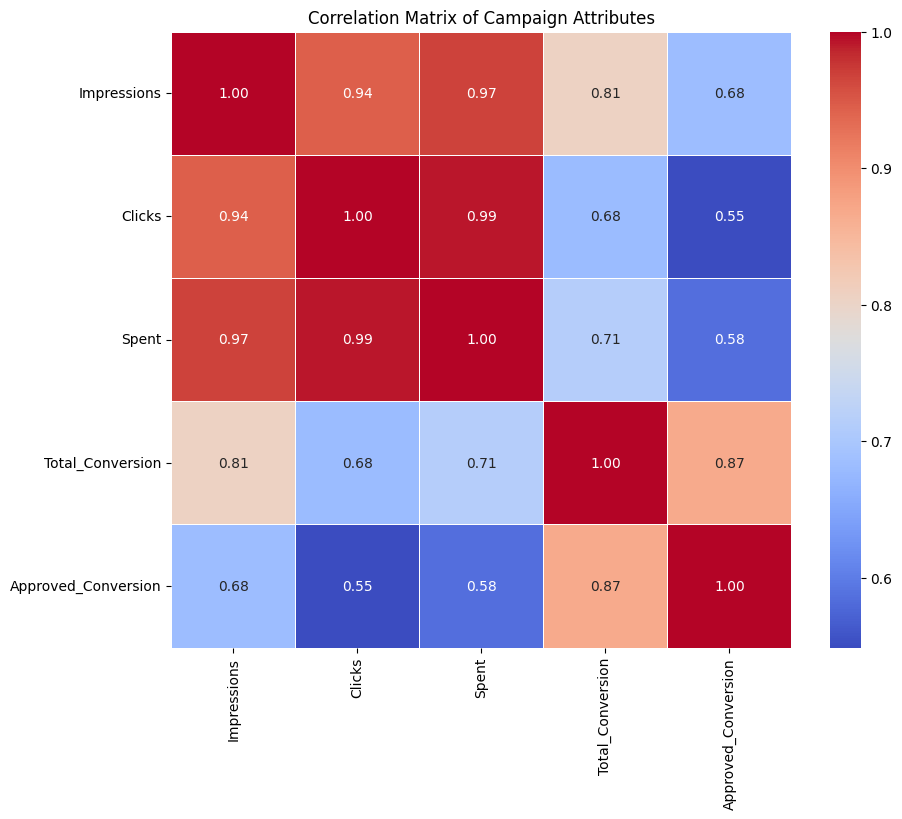

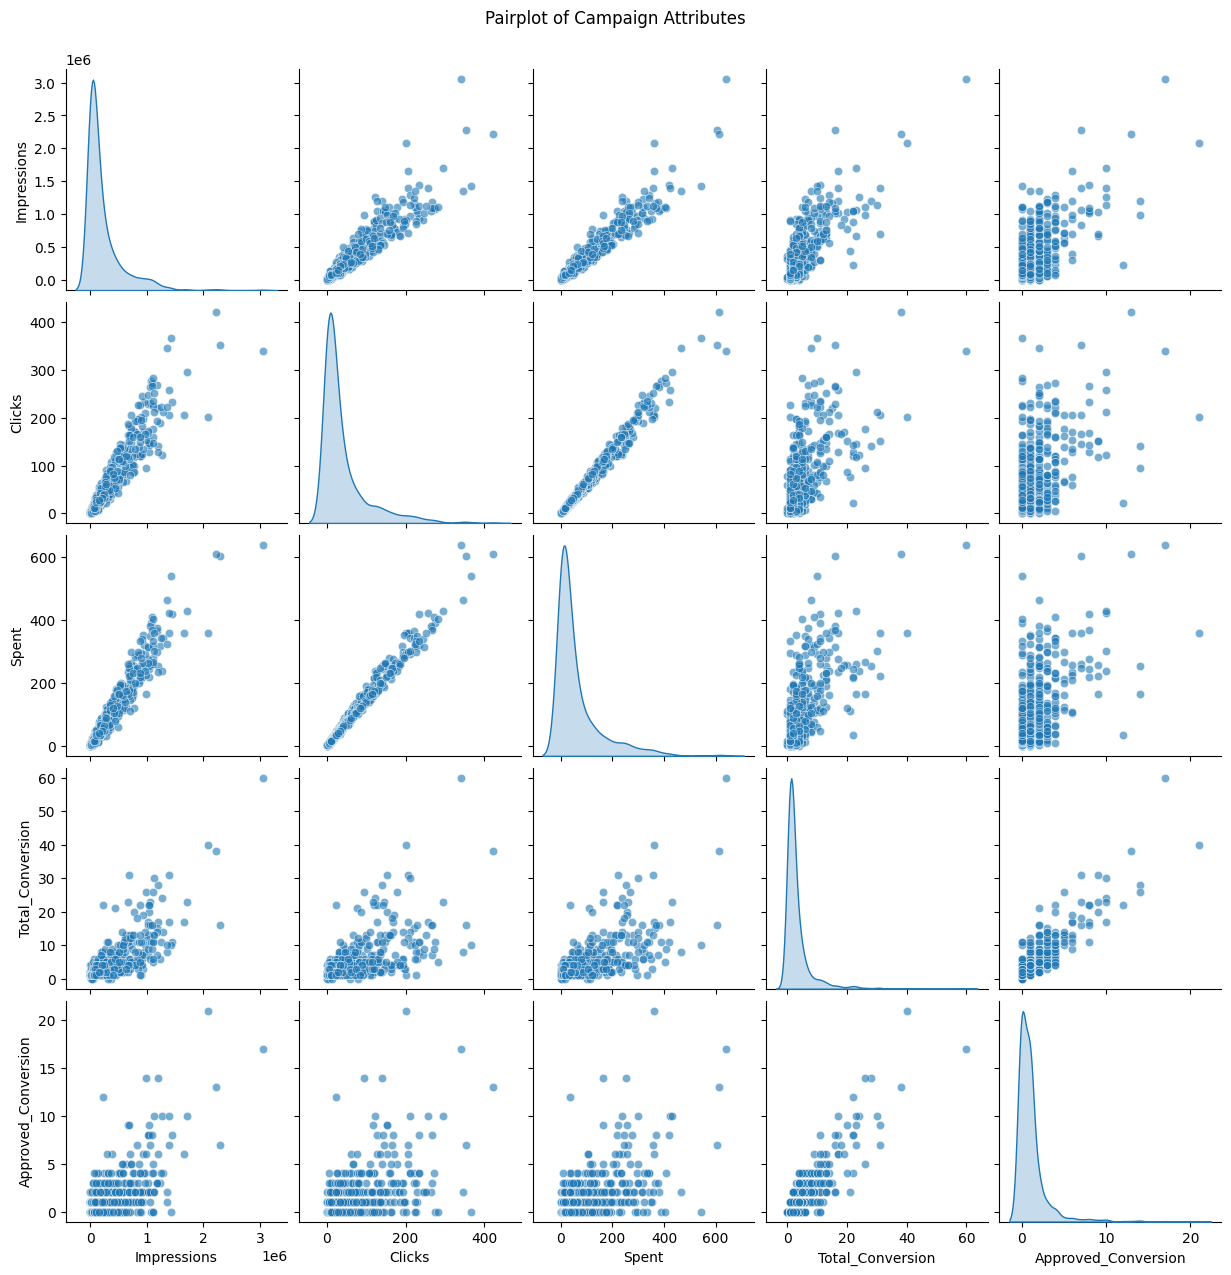

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Lọc dữ liệu hợp lệ
df_filtered = df[(df['Spent'] != 0) & (df['Clicks'] != 0) & (df['Impressions'] != 0)]

# Lấy các thuộc tính cần phân tích
attributes = ['Impressions', 'Clicks', 'Spent', 'Total_Conversion', 'Approved_Conversion']

# 1. Tính ma trận tương quan
correlation_matrix = df_filtered[attributes].corr()

# Vẽ heatmap cho ma trận tương quan
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix of Campaign Attributes")
plt.show()

# 2. Vẽ biểu đồ phân tán giữa các thuộc tính
sns.pairplot(df_filtered[attributes], diag_kind='kde', plot_kws={'alpha': 0.6})
plt.suptitle("Pairplot of Campaign Attributes", y=1.02)
plt.show()


In [8]:
customer_segmentation.head()

Clicks  Total_Conversion  Approved_Conversion
age   gender                                               
30-34 M         4384               737                  263
      F         5099               570                  180
45-49 F         9441               387                  108
40-44 F         5177               310                   89
35-39 M         2933               301                  109

In [9]:
df[df['Approved_Conversion'] == 0]

,ad_id,xyz_campaign_id,fb_campaign_id,age,gender,interest,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion
1,708749,916,103917,30-34,M,16,17861,2,1.820000,2,0
2,708771,916,103920,30-34,M,20,693,0,0.000000,1,0
3,708815,916,103928,30-34,M,28,4259,1,1.250000,1,0
6,708889,916,103940,30-34,M,15,15615,3,4.770000,1,0
8,708953,916,103951,30-34,M,27,2355,1,1.500000,1,0
...,...,...,...,...,...,...,...,...,...,...,...
1126,1314397,1178,179964,40-44,F,111,402975,83,120.899998,1,0
1132,1314404,1178,179971,45-49,F,103,71982,11,16.340001,1,0
1135,1314407,1178,179974,45-49,F,106,107100,23,33.710001,1,0
1139,1314411,1178,179978,45-49,F,110,637549,120,173.880003,3,0


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_30792\4252187067.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Conversion_Rate'] = df_filtered['Total_Conversion'] / df_filtered['Clicks']
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_30792\4252187067.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['ROI'] = (df_filtered['Approved_Conversion'] * 1.0) / df_filtered['Spent']
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_30792\4252187067.py:37: FutureWarning: 

Passing `palette` withou

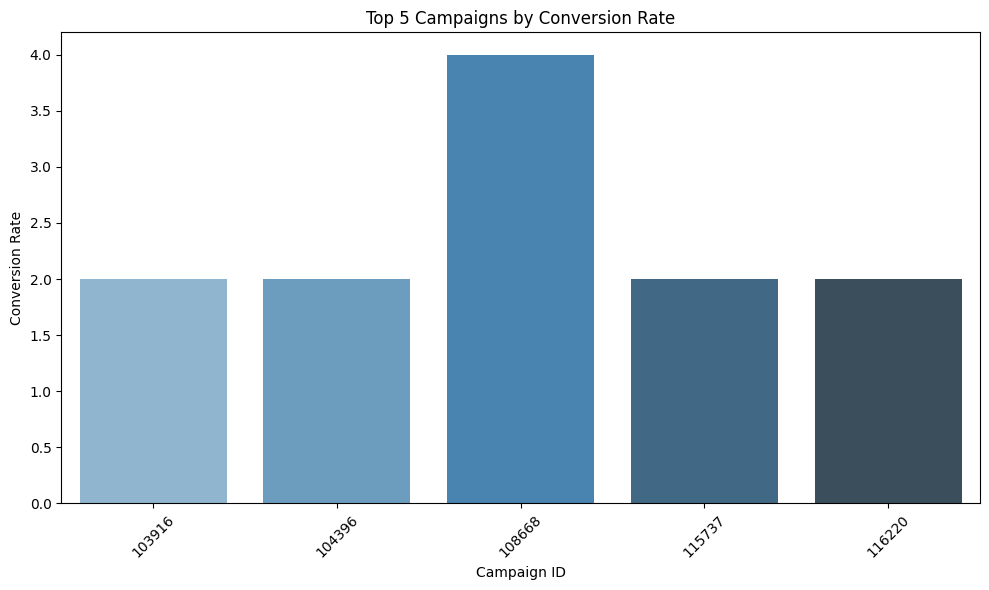

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_30792\4252187067.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_5_campaigns.reset_index(), x='fb_campaign_id', y='ROI', palette='Blues_d')


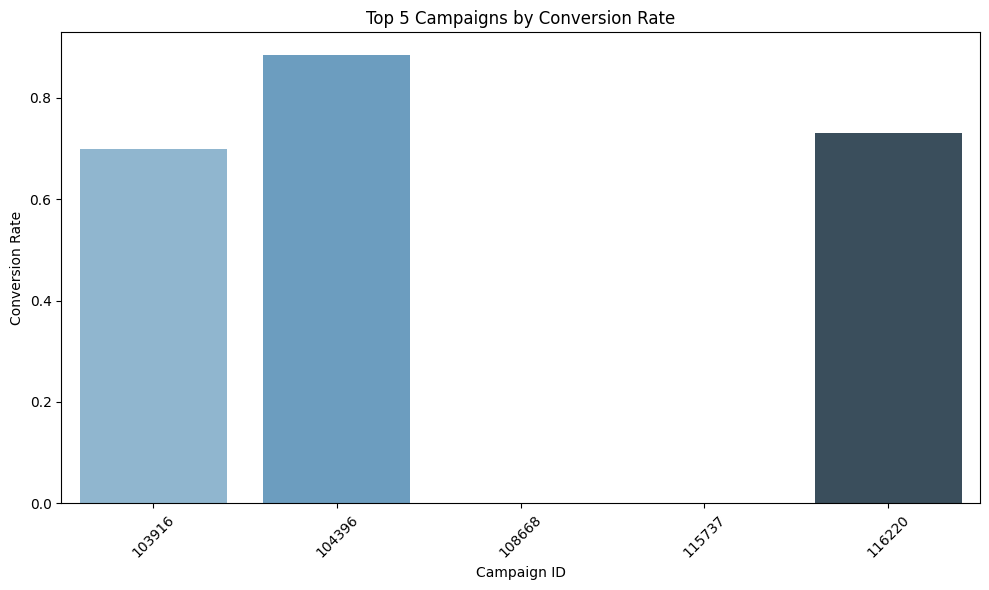

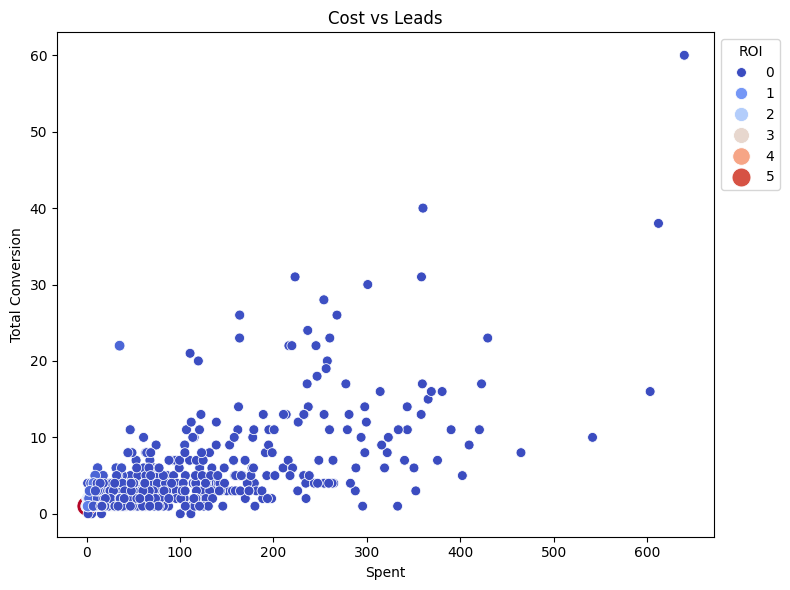

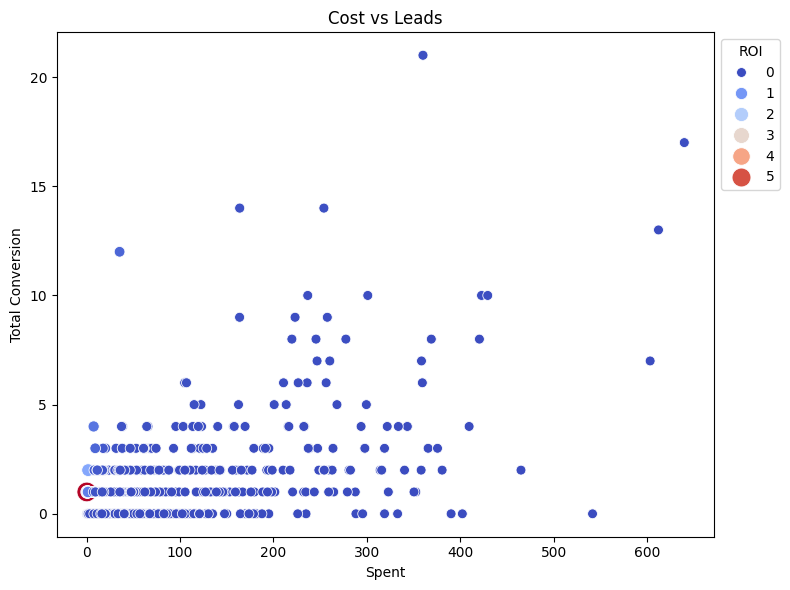

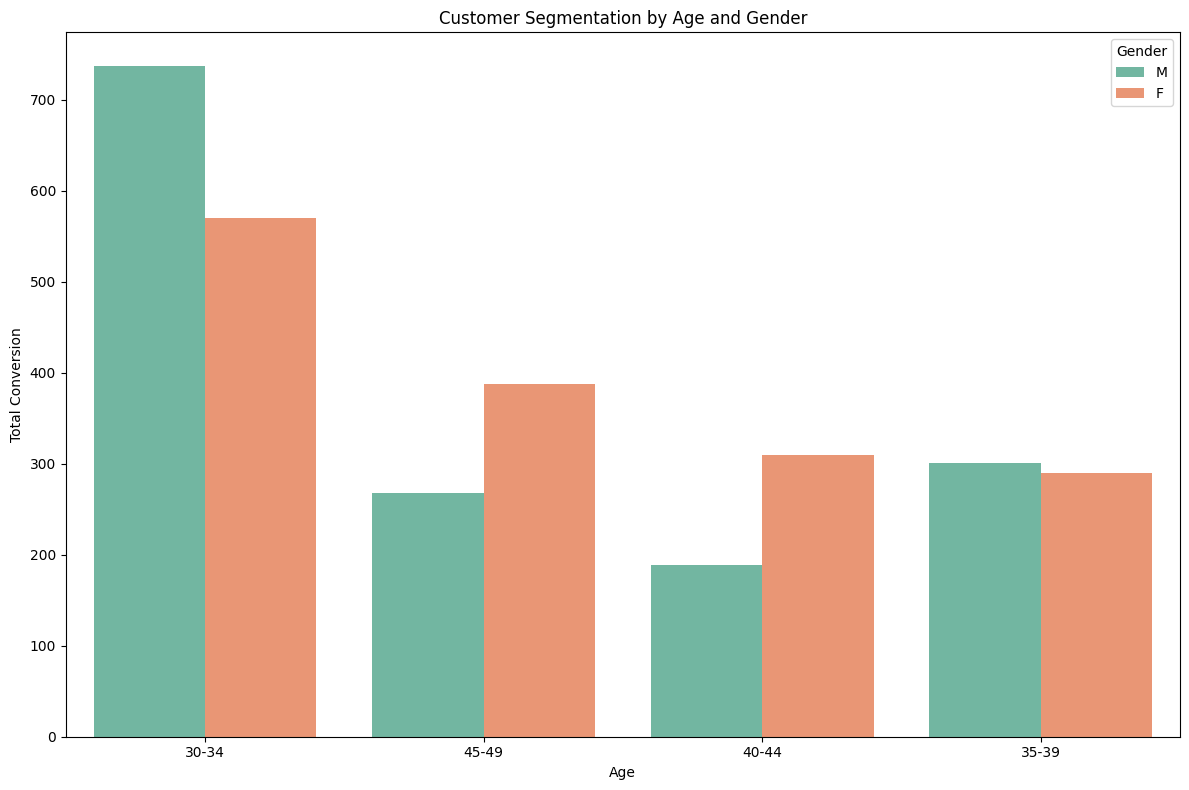

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Lọc dữ liệu không hợp lệ
df_filtered = df[(df['Spent'] != 0) & (df['Clicks'] != 0)]

# Tính Conversion Rate và ROI
df_filtered['Conversion_Rate'] = df_filtered['Total_Conversion'] / df_filtered['Clicks']
df_filtered['ROI'] = (df_filtered['Approved_Conversion'] * 1.0) / df_filtered['Spent']

# Tổng hợp hiệu suất theo chiến dịch
campaign_performance = df_filtered.groupby('fb_campaign_id').agg({
    'Clicks': 'sum',
    'Total_Conversion': 'sum',
    'Approved_Conversion': 'sum',
    'Spent': 'sum',
    'Conversion_Rate': 'mean',
    'ROI': 'mean'
}).sort_values(by=['Conversion_Rate', 'ROI'], ascending=False)

# Mối quan hệ giữa chi phí và khách hàng tiềm năng
correlation_cost_leads = df_filtered[['Spent', 'Total_Conversion']].corr()

# Phân đoạn khách hàng theo tuổi và giới tính
customer_segmentation = df_filtered.groupby(['age', 'gender']).agg({
    'Clicks': 'sum',
    'Total_Conversion': 'sum',
    'Approved_Conversion': 'sum'
}).sort_values(by='Total_Conversion', ascending=False)

# ----- VẼ BIỂU ĐỒ -----

# 1. Biểu đồ thanh: Top 5 chiến dịch theo tỷ lệ chuyển đổi clicks -> Conversion
plt.figure(figsize=(10, 6))
top_5_campaigns = campaign_performance.head(5)
sns.barplot(data=top_5_campaigns.reset_index(), x='fb_campaign_id', y='Conversion_Rate', palette='Blues_d')
plt.title("Top 5 Campaigns by Conversion Rate")
plt.xlabel("Campaign ID")
plt.ylabel("Conversion Rate")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 1. Biểu đồ thanh: Top 5 chiến dịch theo ROI
plt.figure(figsize=(10, 6))
top_5_campaigns = campaign_performance.head(5)
sns.barplot(data=top_5_campaigns.reset_index(), x='fb_campaign_id', y='ROI', palette='Blues_d')
plt.title("Top 5 Campaigns by Conversion Rate")
plt.xlabel("Campaign ID")
plt.ylabel("Conversion Rate")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# 2. Biểu đồ phân tán: Mối quan hệ giữa chi phí và số khách hàng tiềm năng
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_filtered, x='Spent', y='Total_Conversion', hue='ROI', palette='coolwarm', size='ROI', sizes=(50, 200))
plt.title("Cost vs Leads")
plt.xlabel("Spent")
plt.ylabel("Total Conversion")
plt.legend(title="ROI", loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

# 2. Biểu đồ phân tán: Mối quan hệ giữa chi phí và số khách hàng tiềm năng
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_filtered, x='Spent', y='Approved_Conversion', hue='ROI', palette='coolwarm', size='ROI', sizes=(50, 200))
plt.title("Cost vs Leads")
plt.xlabel("Spent")
plt.ylabel("Total Conversion")
plt.legend(title="ROI", loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

# 3. Biểu đồ cột: Phân đoạn khách hàng theo tuổi và giới tính
customer_segmentation_reset = customer_segmentation.reset_index()
plt.figure(figsize=(12, 8))
sns.barplot(data=customer_segmentation_reset, x='age', y='Total_Conversion', hue='gender', palette='Set2')
plt.title("Customer Segmentation by Age and Gender")
plt.xlabel("Age")
plt.ylabel("Total Conversion")
plt.legend(title="Gender")
plt.tight_layout()
plt.show()


In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Đọc dữ liệu
file_path = '../data/raw/KAG_conversion_data.csv'
data = pd.read_csv(file_path)

# Loại bỏ cột không cần thiết
data_cleaned = data.drop(columns=['ad_id', 'fb_campaign_id'])

# Mã hóa các cột phân loại
categorical_cols = ['age', 'gender']
encoder = OneHotEncoder(sparse_output=False, drop='first')  # Thay 'sparse' thành 'sparse_output'
encoded_categorical = encoder.fit_transform(data_cleaned[categorical_cols])
encoded_feature_names = encoder.get_feature_names_out(categorical_cols)

# Tạo DataFrame sau khi mã hóa
encoded_df = pd.DataFrame(encoded_categorical, columns=encoded_feature_names)
data_encoded = pd.concat([data_cleaned.drop(columns=categorical_cols), encoded_df], axis=1)

# Chia dữ liệu thành train/test
X = data_encoded.drop(columns=['Total_Conversion'])
y = data_encoded['Total_Conversion']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Huấn luyện mô hình Random Forest Regressor
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Dự đoán và đánh giá hiệu quả
y_pred = model.predict(X_test)

# RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# MSE (Mean Squared Error)
mse = mean_squared_error(y_test, y_pred)

# MAE (Mean Absolute Error)
mae = mean_absolute_error(y_test, y_pred)

# R-squared
r2 = r2_score(y_test, y_pred)

# Hiển thị kết quả
print("Feature Importances:", model.feature_importances_)  # Hiển thị độ quan trọng của các tính năng
print("RMSE:", rmse)
print("MSE:", mse)
print("MAE:", mae)
print("R-squared:", r2)

# Một vài dự đoán mẫu
sample_results = pd.DataFrame({
    "Actual": y_test[:5].values,
    "Predicted": y_pred[:5]
})
print(sample_results)


Feature Importances: [3.66612208e-04 2.92385710e-02 2.23385533e-01 2.70955329e-02
 5.43485274e-02 6.46531307e-01 4.78695936e-03 4.17878437e-03
 6.23168022e-03 3.83649222e-03]
RMSE: 1.6222071061354981
MSE: 2.6315558951965072
MAE: 0.8055458515283842
R-squared: 0.8605440517598553
   Actual  Predicted
0       1       1.00
1       2       2.48
2       3       1.04
3       1       1.59
4       1       1.09


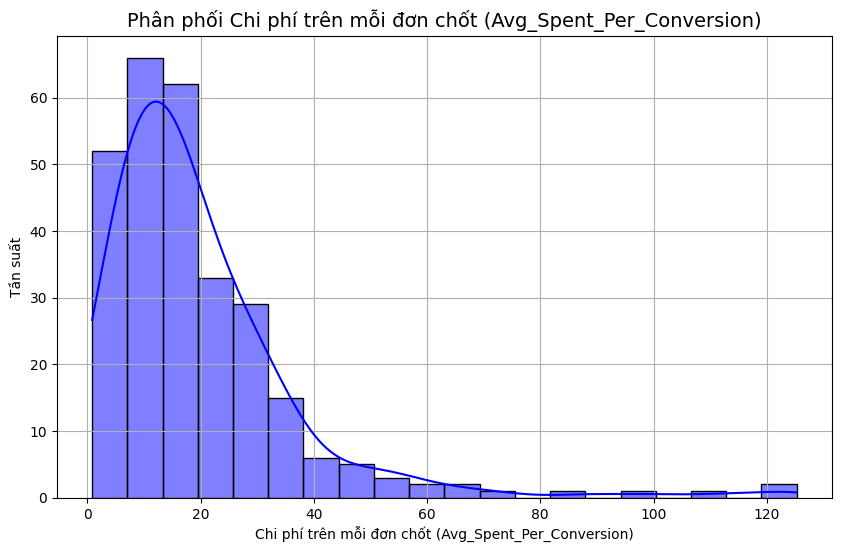

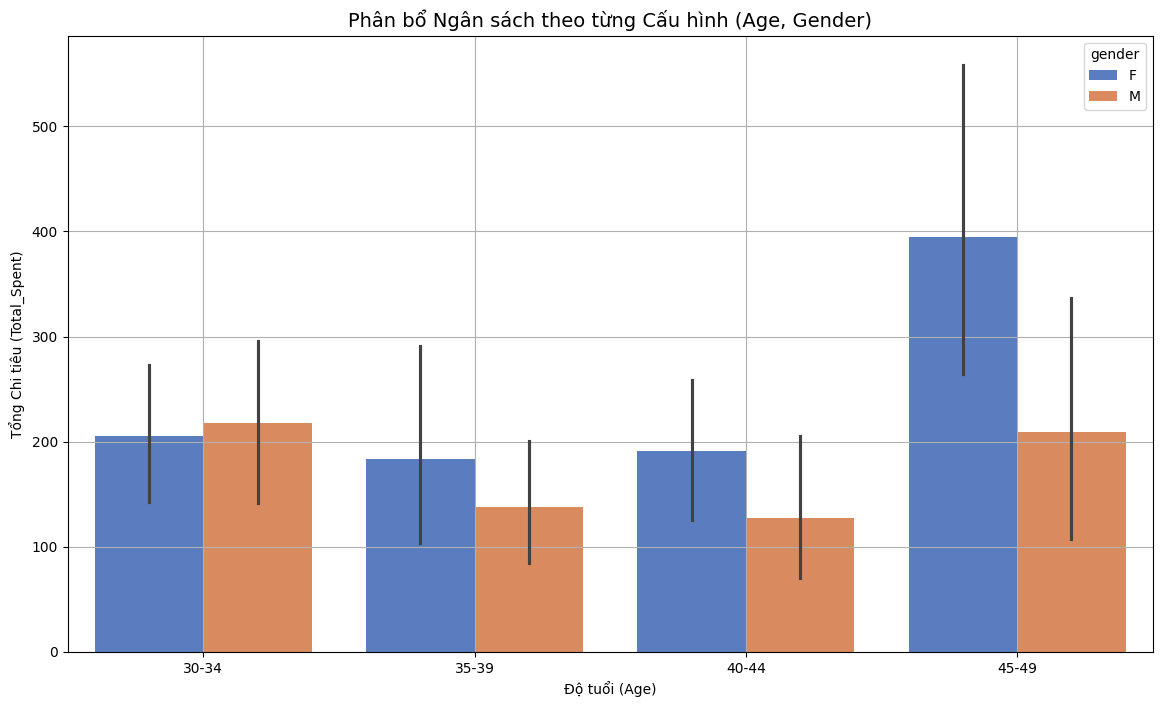

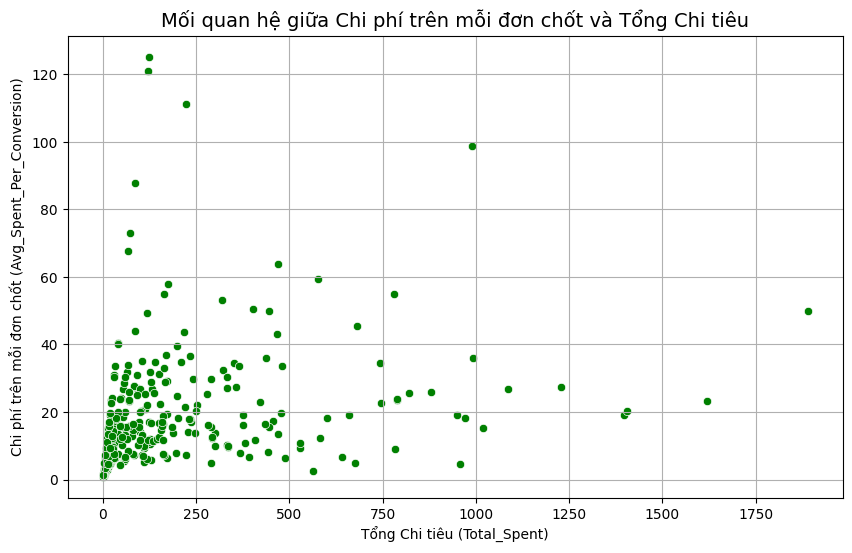

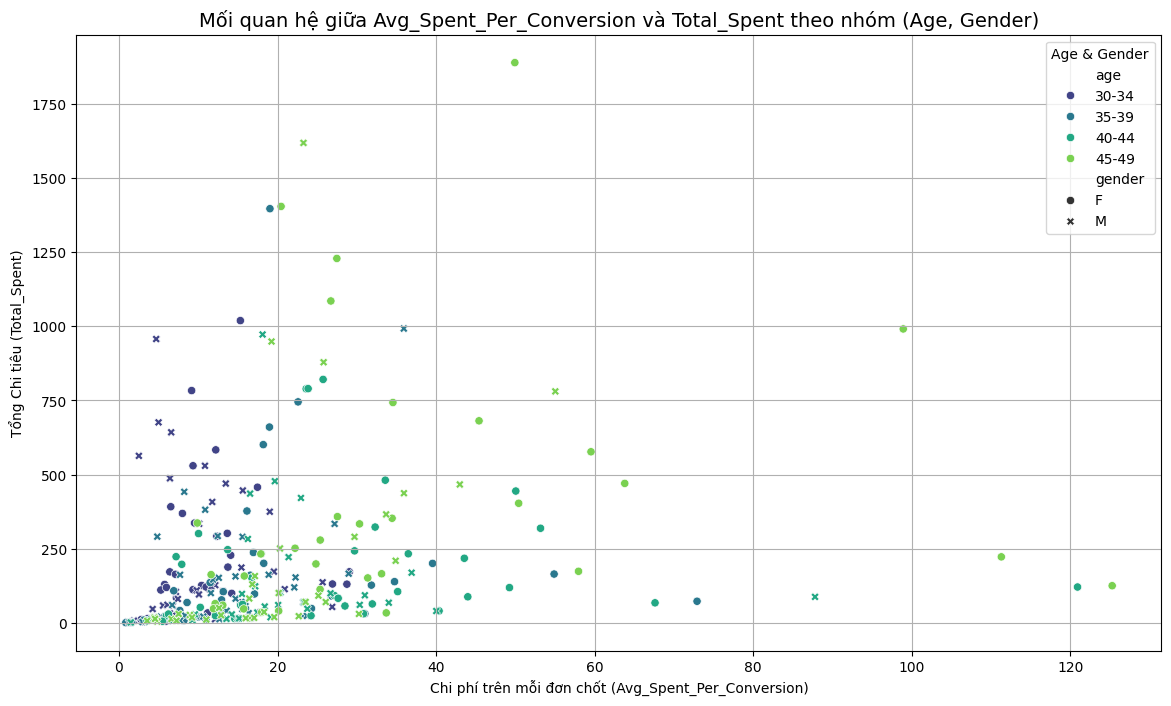

       age gender  interest  Avg_Spent_Per_Conversion  Total_Spent
89   35-39      F        31                  0.860000     0.860000
70   30-34      M       112                  1.066667     3.200000
123  35-39      M        31                  1.290000     1.290000
10   30-34      F        23                  1.310000     1.310000
64   30-34      M       102                  1.345000     2.690000
..     ...    ...       ...                       ...          ...
33   30-34      F       109                 11.576667   138.920001
128  35-39      M        65                 11.585250   100.370001
236  45-49      F       104                 11.617143   162.639997
58   30-34      M        63                 11.632708   121.839999
49   30-34      M        25                 11.763253   407.700001

[100 rows x 5 columns]


In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Tải và xử lý dữ liệu
file_path = '../data/raw/KAG_conversion_data.csv'
data = pd.read_csv(file_path)

data = data[(data['Spent'] != 0) | (data['Clicks'] != 0)]
data = data[(data['Total_Conversion'] != 0)]

# Tính chi phí trung bình trên mỗi đơn chốt
data['Cost_per_Conversion'] = data['Spent'] / data['Total_Conversion']

# Tính trung bình chi phí cho từng nhóm
grouped_data = data.groupby(['age', 'gender', 'interest']).agg(
    Avg_Spent_Per_Conversion=('Cost_per_Conversion', 'mean'),
    Total_Spent=('Spent', 'sum'),
).reset_index()

# Lọc bỏ cấu hình không hợp lệ (Avg_Spent_Per_Conversion = 0 hoặc NaN)
grouped_data = grouped_data[grouped_data['Avg_Spent_Per_Conversion'] > 0].reset_index(drop=True)

# Bước 1: Vẽ biểu đồ phân phối chi phí trên mỗi đơn chốt
plt.figure(figsize=(10, 6))
sns.histplot(grouped_data['Avg_Spent_Per_Conversion'], kde=True, bins=20, color='blue')
plt.title('Phân phối Chi phí trên mỗi đơn chốt (Avg_Spent_Per_Conversion)', fontsize=14)
plt.xlabel('Chi phí trên mỗi đơn chốt (Avg_Spent_Per_Conversion)')
plt.ylabel('Tần suất')
plt.grid(True)
plt.show()

# Bước 2: Biểu đồ phân bổ ngân sách theo từng cấu hình (Total_Spent theo Age, Gender, Interest)
plt.figure(figsize=(14, 8))
sns.barplot(x='age', y='Total_Spent', hue='gender', data=grouped_data, palette='muted')
plt.title('Phân bổ Ngân sách theo từng Cấu hình (Age, Gender)', fontsize=14)
plt.xlabel('Độ tuổi (Age)')
plt.ylabel('Tổng Chi tiêu (Total_Spent)')
plt.grid(True)
plt.show()

# Bước 3: Mối quan hệ giữa Chi phí trên mỗi đơn chốt và Tổng Chi tiêu
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Total_Spent', y='Avg_Spent_Per_Conversion', data=grouped_data, color='green')
plt.title('Mối quan hệ giữa Chi phí trên mỗi đơn chốt và Tổng Chi tiêu', fontsize=14)
plt.xlabel('Tổng Chi tiêu (Total_Spent)')
plt.ylabel('Chi phí trên mỗi đơn chốt (Avg_Spent_Per_Conversion)')
plt.grid(True)
plt.show()

# Bước 4: Biểu đồ mối quan hệ giữa Avg_Spent_Per_Conversion và Total_Spent theo từng nhóm (Age, Gender)
plt.figure(figsize=(14, 8))
sns.scatterplot(x='Avg_Spent_Per_Conversion', y='Total_Spent', hue='age', style='gender', data=grouped_data, palette='viridis')
plt.title('Mối quan hệ giữa Avg_Spent_Per_Conversion và Total_Spent theo nhóm (Age, Gender)', fontsize=14)
plt.xlabel('Chi phí trên mỗi đơn chốt (Avg_Spent_Per_Conversion)')
plt.ylabel('Tổng Chi tiêu (Total_Spent)')
plt.grid(True)
plt.legend(title='Age & Gender')
plt.show()

# Kiểm tra 100 cấu hình có chi phí và chi tiêu thấp nhất
print(grouped_data.sort_values(by=['Avg_Spent_Per_Conversion', 'Total_Spent'], ascending=True).head(100))


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_30792\2507157554.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.interest)


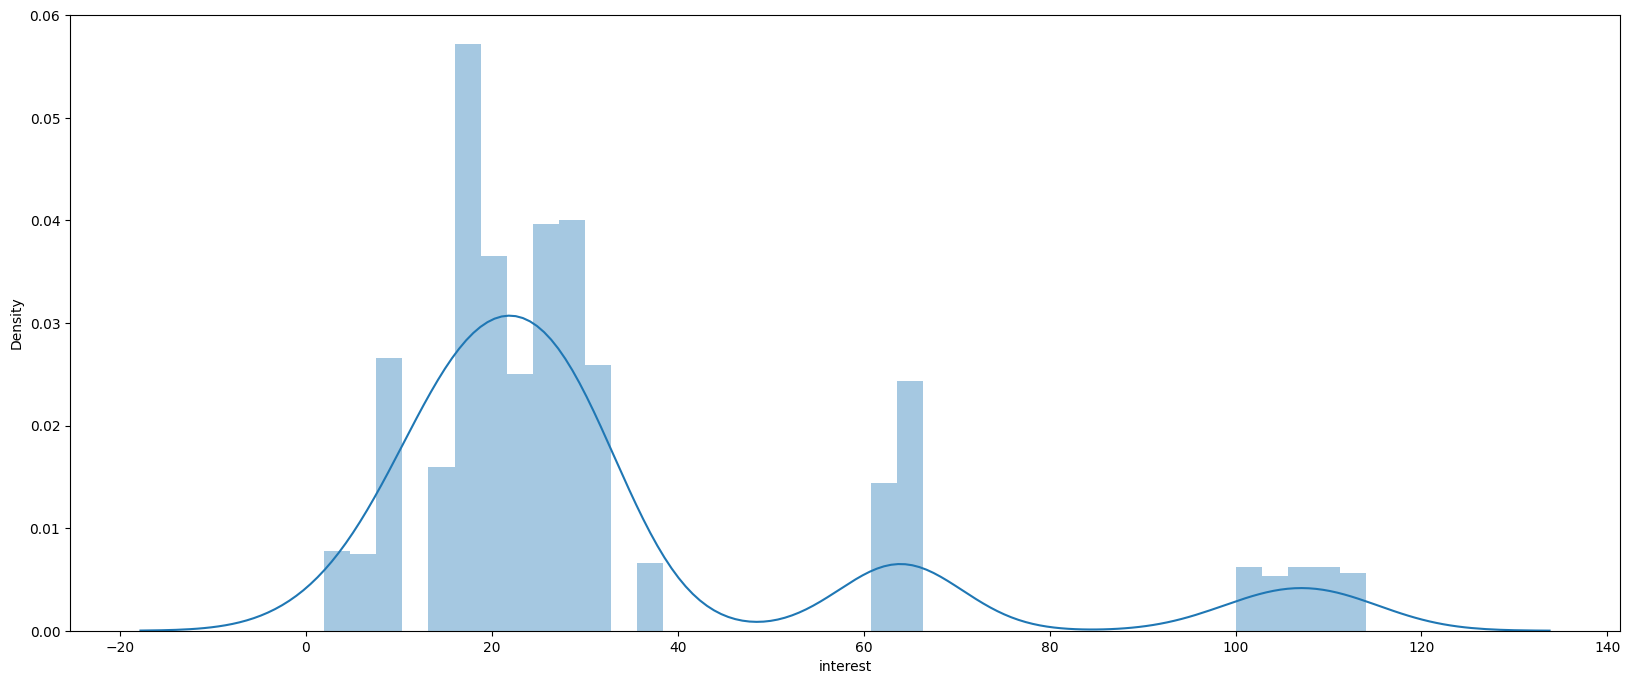

In [14]:
file_path = '../data/raw/KAG_conversion_data.csv'
df = pd.read_csv(file_path)

# Chiến dịch nào có tỷ lệ chuyển đổi cao nhất
#plot of interest
#most of the people seem to be interested in 16

plt.figure(figsize = (20,8))
sns.distplot(df.interest)
plt.show()

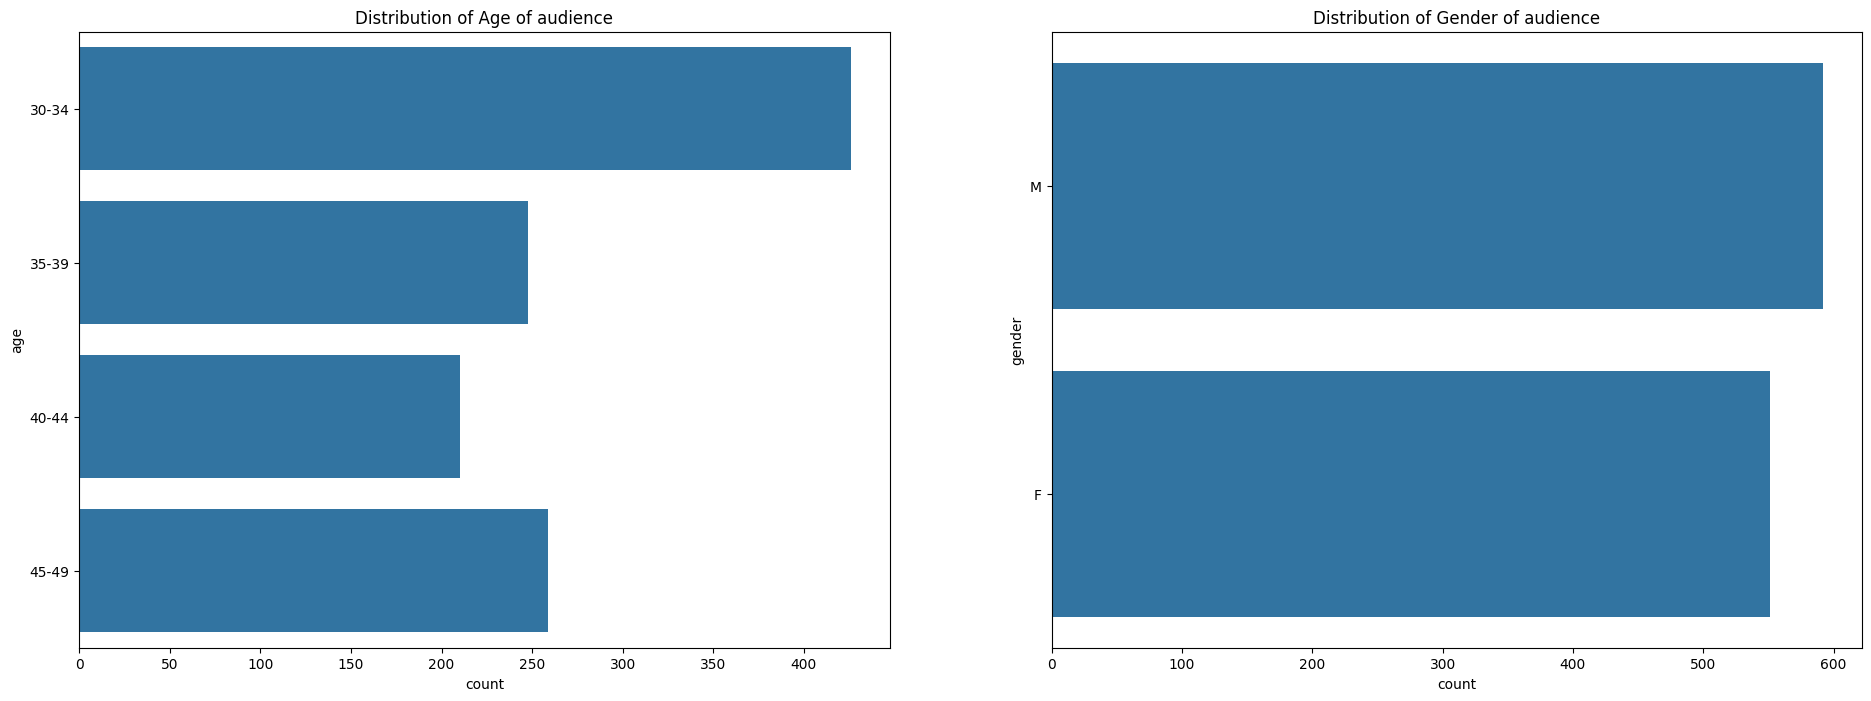

In [15]:
#most of the people in 30-34 range
plt.figure(figsize = (23,8))

plt.subplot(1,2,1)
plt.title('Distribution of Age of audience')
sns.countplot(df.age)

plt.subplot(1,2,2)
plt.title('Distribution of Gender of audience')
sns.countplot(df.gender)
plt.show()

<Figure size 2000x800 with 0 Axes>

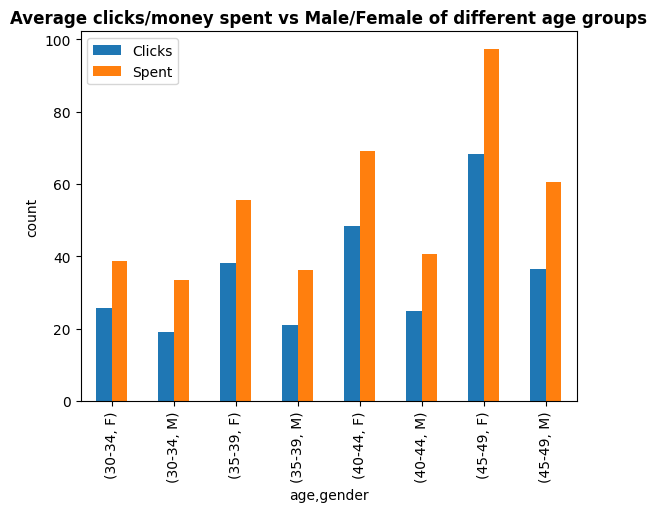

In [16]:
#females spent a lot more than males in all age group

plt.figure(figsize = (20,8))

df.groupby(['age', 'gender'])[['Clicks','Spent']].mean().plot.bar()
plt.title('Average clicks/money spent vs Male/Female of different age groups', fontweight="bold")
plt.ylabel('count')

plt.show()

Inference -
from the plot of average click and average money spent by both gender of different ages reveal - females spend much more than males(highest of age range 45-49) and also click on the ads more often
seems like females could be target audience in terms of more effective reach for organisations

In [17]:
# Analysing in terms of Age

df = df.groupby('age').sum().drop(['ad_id', 'xyz_campaign_id', 'fb_campaign_id'], axis = 1)
df.reset_index(inplace = True)
df

,age,gender,interest,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion
0,30-34,MMMMMMMMMMMMMMMMMMFFFFFFFFFFFMMMMMMMMMFFFFFFFF...,13130,67993019,9483,15252.399986,1431,494
1,35-39,MMMMMMMMMFFFMMMMMMMMFFFFFFFFFMMMFMMMMMMFFFFFFM...,8400,42104644,7094,11112.429994,626,207
2,40-44,MMMMMFMMFFFFFFFMMFFFFFFFFMMFFFFFMMMMMMMMMMMMMM...,7230,39604307,7736,11589.729981,523,170
3,45-49,MMMFFFFMMMMFFFFFFFMMMMMFFFFFFFMMMMMFFFFFFFFFFF...,8692,63732858,13852,20750.669997,684,208


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_30792\1592628613.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = df, x = 'age', y = 'Clicks', palette='magma')
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_30792\1592628613.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = df, x = 'age', y = 'Total_Conversion', palette='Spectral_r')


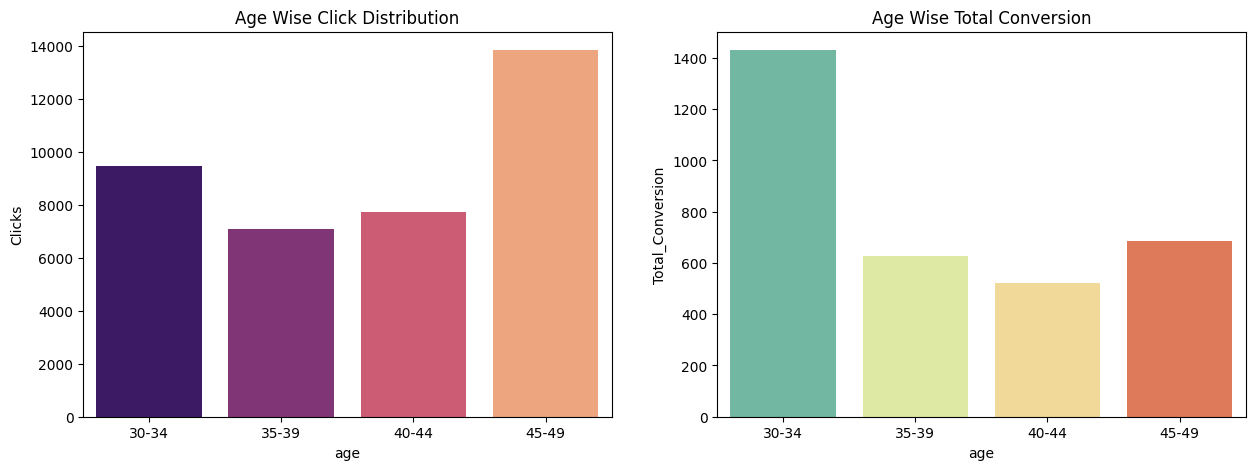

In [18]:
plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
plt.title('Age Wise Click Distribution')
sns.barplot(data = df, x = 'age', y = 'Clicks', palette='magma')

plt.subplot(1,2,2)
plt.title('Age Wise Total Conversion')
sns.barplot(data = df, x = 'age', y = 'Total_Conversion', palette='Spectral_r')

plt.show()

Inference -
People of age group 45-49 click the most on ads shown.
however, audience of age 30-34 have highest conversion rate, so is 45-49 more mature in average because they click but don't buy too often??(umm ofc!!)

Analysing Different Ads Campaign - on what factors did success of each campaign depends?

In [19]:
file_path = '../data/raw/KAG_conversion_data.csv'
df = pd.read_csv(file_path)

df2 = df.groupby('xyz_campaign_id').sum().drop(['ad_id', 'fb_campaign_id', 'interest'], axis = 1)
df2.reset_index(inplace = True)
df2

,xyz_campaign_id,age,gender,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion
0,916,30-3430-3430-3430-3430-3430-3430-3430-3430-343...,MMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMFFFFFFFFFFF...,482925,113,149.710001,58,24
1,936,30-3430-3430-3430-3430-3430-3430-3430-3430-343...,MMMMMMMMMMMMMMMMMMMMMMMFFFFFFFFFFFFFFFFFFFFFFF...,8128187,1984,2893.369999,537,183
2,1178,30-3430-3430-3430-3430-3430-3430-3430-3430-343...,MMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMM...,204823716,36068,55662.149959,2669,872


In [20]:
df2['Campaign_name'] = ['Campaign A (916)', 'Campaign B (936)', 'Campaign C (1178)']
df2

,xyz_campaign_id,age,gender,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion,Campaign_name
0,916,30-3430-3430-3430-3430-3430-3430-3430-3430-343...,MMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMFFFFFFFFFFF...,482925,113,149.710001,58,24,Campaign A (916)
1,936,30-3430-3430-3430-3430-3430-3430-3430-3430-343...,MMMMMMMMMMMMMMMMMMMMMMMFFFFFFFFFFFFFFFFFFFFFFF...,8128187,1984,2893.369999,537,183,Campaign B (936)
2,1178,30-3430-3430-3430-3430-3430-3430-3430-3430-343...,MMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMM...,204823716,36068,55662.149959,2669,872,Campaign C (1178)


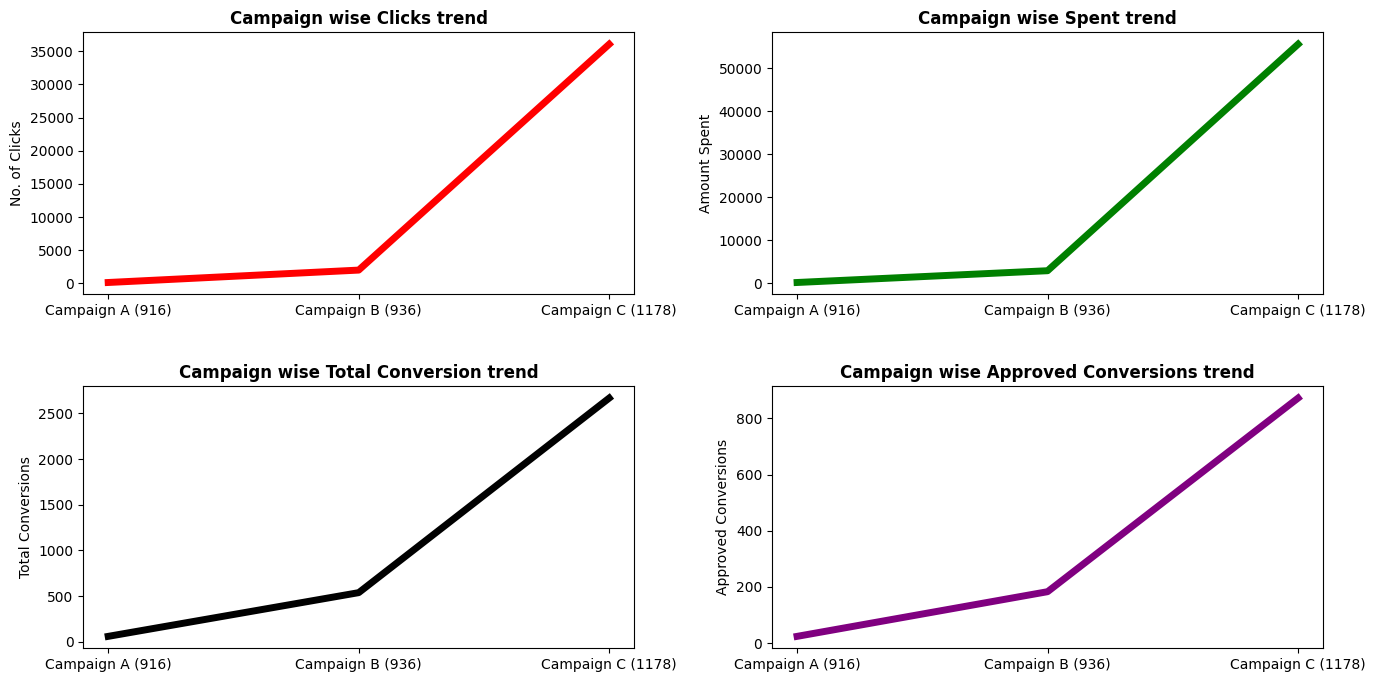

In [21]:
fig,axes = plt.subplots(nrows=2,ncols=2,figsize=(16,8))


axes[0][0].plot(df2['Campaign_name'], df2['Clicks'], 
                color = 'Red', lw = 5)
axes[0][0].set_title('Campaign wise Clicks trend', fontweight = 1000)
axes[0][0].set_ylabel('No. of Clicks')


axes[0][1].plot(df2['Campaign_name'], df2['Spent'], 
                color = 'Green', lw = 5)
axes[0][1].set_title('Campaign wise Spent trend', fontweight = 1000)
axes[0][1].set_ylabel('Amount Spent')

axes[1][0].plot(df2['Campaign_name'], df2['Total_Conversion'], 
                color = 'Black', lw = 5)
axes[1][0].set_title('Campaign wise Total Conversion trend', fontweight = 1000)
axes[1][0].set_ylabel("Total Conversions")

axes[1][1].plot(df2['Campaign_name'], df2['Approved_Conversion'],
               color = 'Purple', lw = 5)
axes[1][1].set_title("Campaign wise Approved Conversions trend", fontweight = 1000)
axes[1][1].set_ylabel('Approved Conversions')

fig.subplots_adjust(wspace=0.25, hspace=0.35,)

inference-
Campaign A seems to be least and Campaign C seems to be maximum success.
Clearly, The important factor is the amount of money spent by company and the impressions - so more publicity directly affects total conversion and approved conversion (makes sense intuitively)

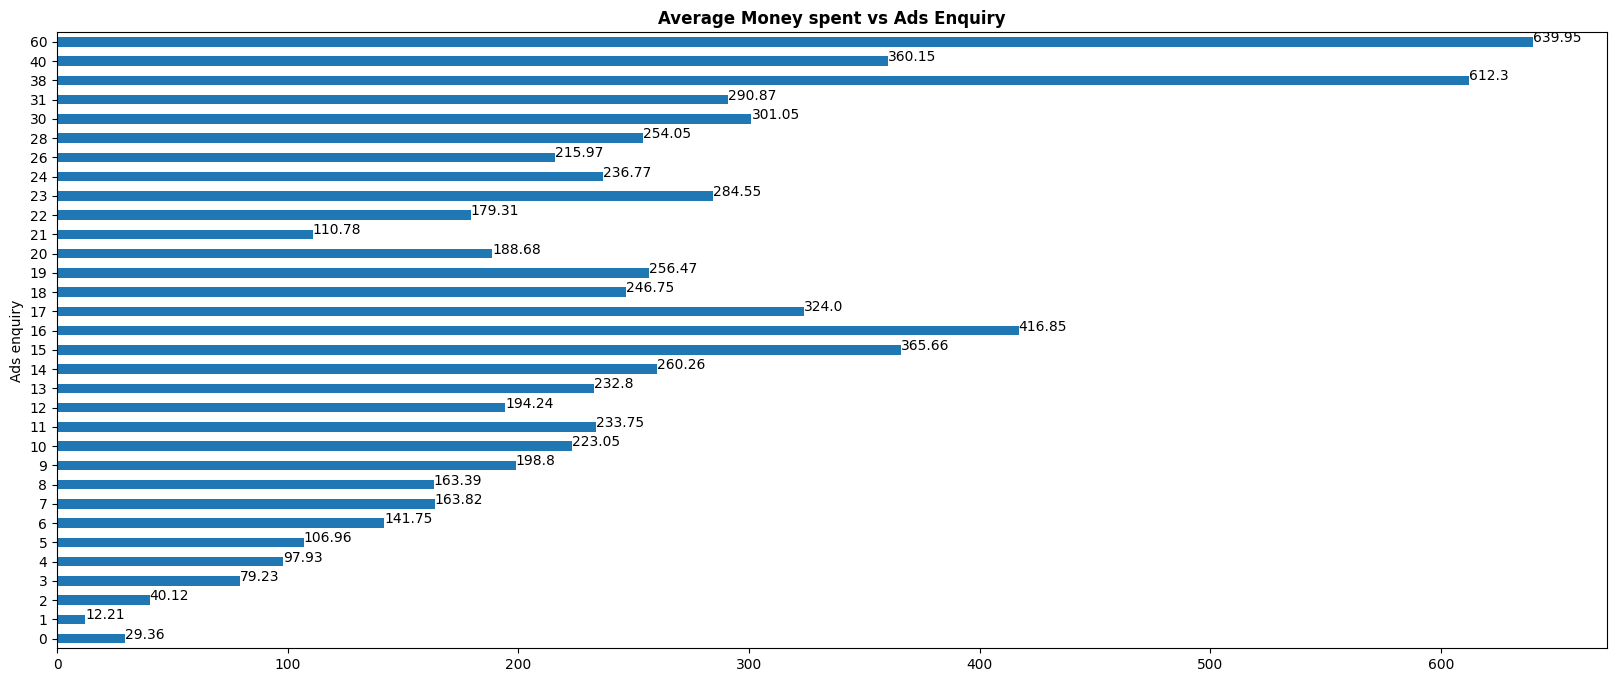

In [22]:
plt.figure(figsize=(20,8))

df.groupby('Total_Conversion')['Spent'].mean().plot.barh()
plt.title('Average Money spent vs Ads Enquiry', fontweight="bold")
plt.ylabel('Ads enquiry')

abc= round(df.groupby('Total_Conversion')['Spent'].mean(),2)

#mention the value of mean in plots
for index, value in enumerate(abc):
    plt.text(value, index, str(value))  

inference -
The plot of average ads enquiry or people who enquired about product vs the money spent on the ads by companies reveal that - distribution seems to be skewed towards higher values i.e. more money spent implies more ads enquiry.
also, When the company spent an average of

$10-200 on Ads, then, they got 120 Ads enquiry in return.

$200-400 on Ads, then, they got 319 Ads enquiry in return.

$400 on Ads, then, they got 114 Ads enquiry in return.

We can conclude that spending between $200-400 on Ads seems reasonable for any company because it yields the max Ads enquiry.

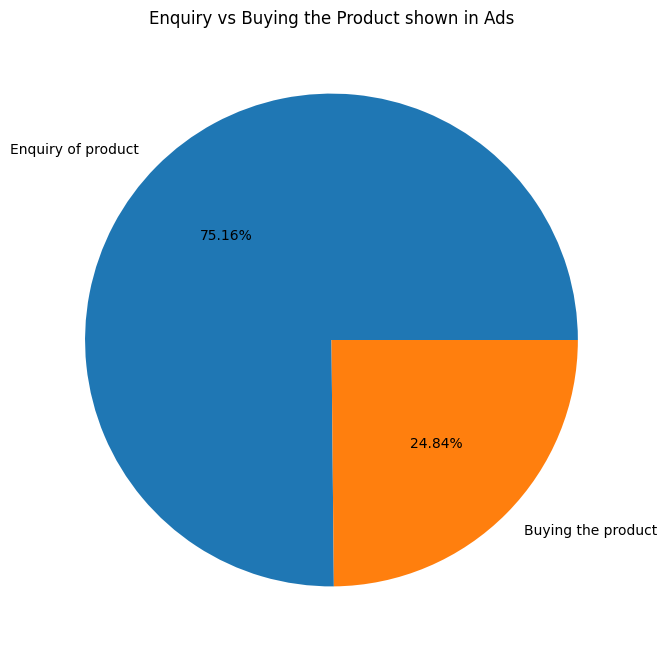

In [23]:
plt.figure(figsize=(20,8))

value=[df['Total_Conversion'].mean(), df['Approved_Conversion'].mean()]
labels= ['Enquiry of product', 'Buying the product']
plt.title('Enquiry vs Buying the Product shown in Ads')
plt.pie(value, labels = labels, autopct='%.2f%%')

plt.show()

inference -
About 75% of people only enquired about the product and about 25% actually buyed it - quite typical of the buying habits of people in market

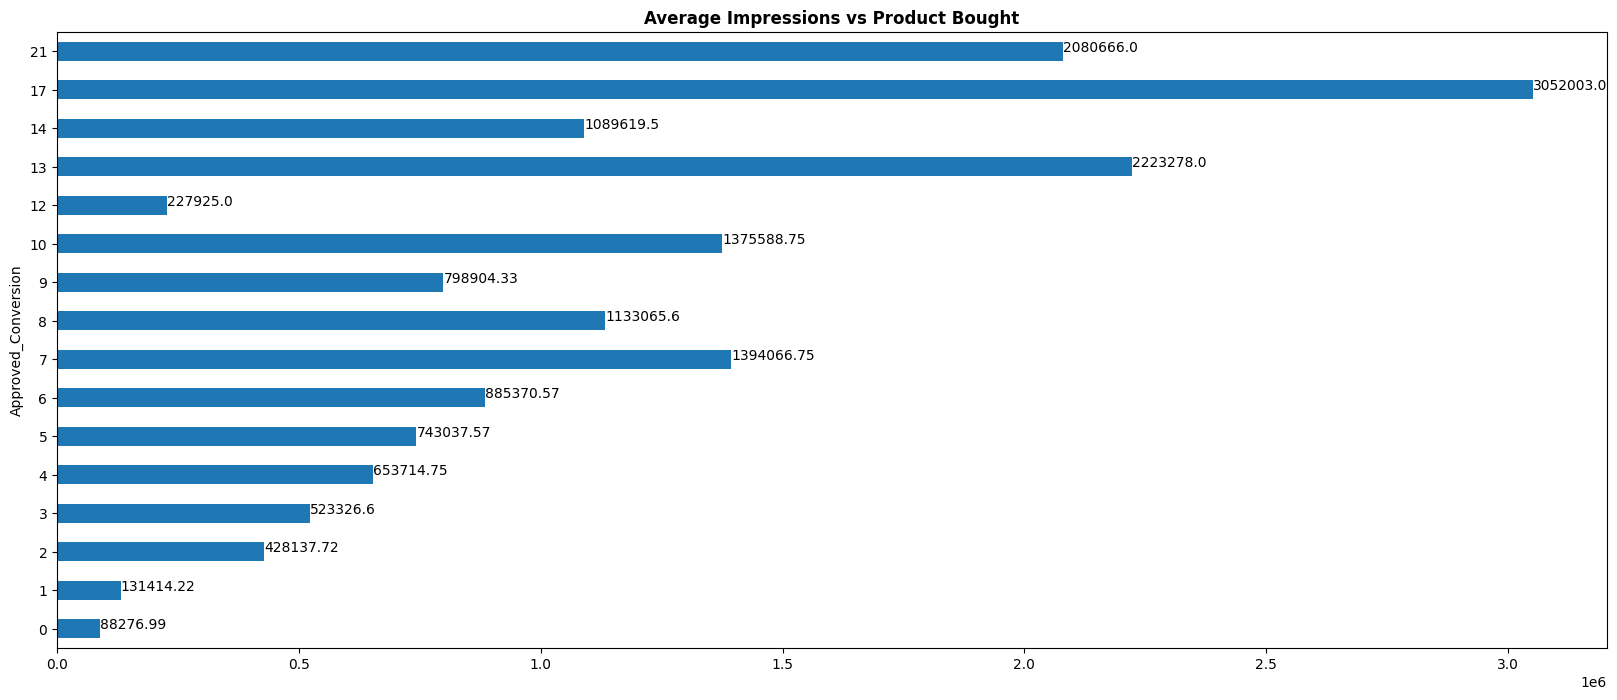

In [24]:
#skewed towards higher values
plt.figure(figsize=(20,8))

df.groupby(['Approved_Conversion'])['Impressions'].mean().plot.barh()
x = round(df.groupby(['Approved_Conversion'])['Impressions'].mean(),2)
plt.title('Average Impressions vs Product Bought', fontweight="bold")

#to put the value above the bar
for index, value in enumerate(x):
    plt.text(value, index, str(value))

Clearly, More impression implies more publicity and thus more people will buy it.

Does Variation with age and gender affects impressions ?

In [25]:
#separate male and female
women= df[df['gender']=='F']
men= df[df['gender']=='M']

above_average_men = men[men['Impressions'] > df.Impressions.mean()]
above_average_women = women[women['Impressions'] > df.Impressions.mean()]

below_average_men = men[men['Impressions'] < df.Impressions.mean()]
below_average_women = women[women['Impressions'] < df.Impressions.mean()]

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_30792\2265318992.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(above_average_men.Clicks , label = 'Men Clicks')
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_30792\2265318992.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(above_average_women.C

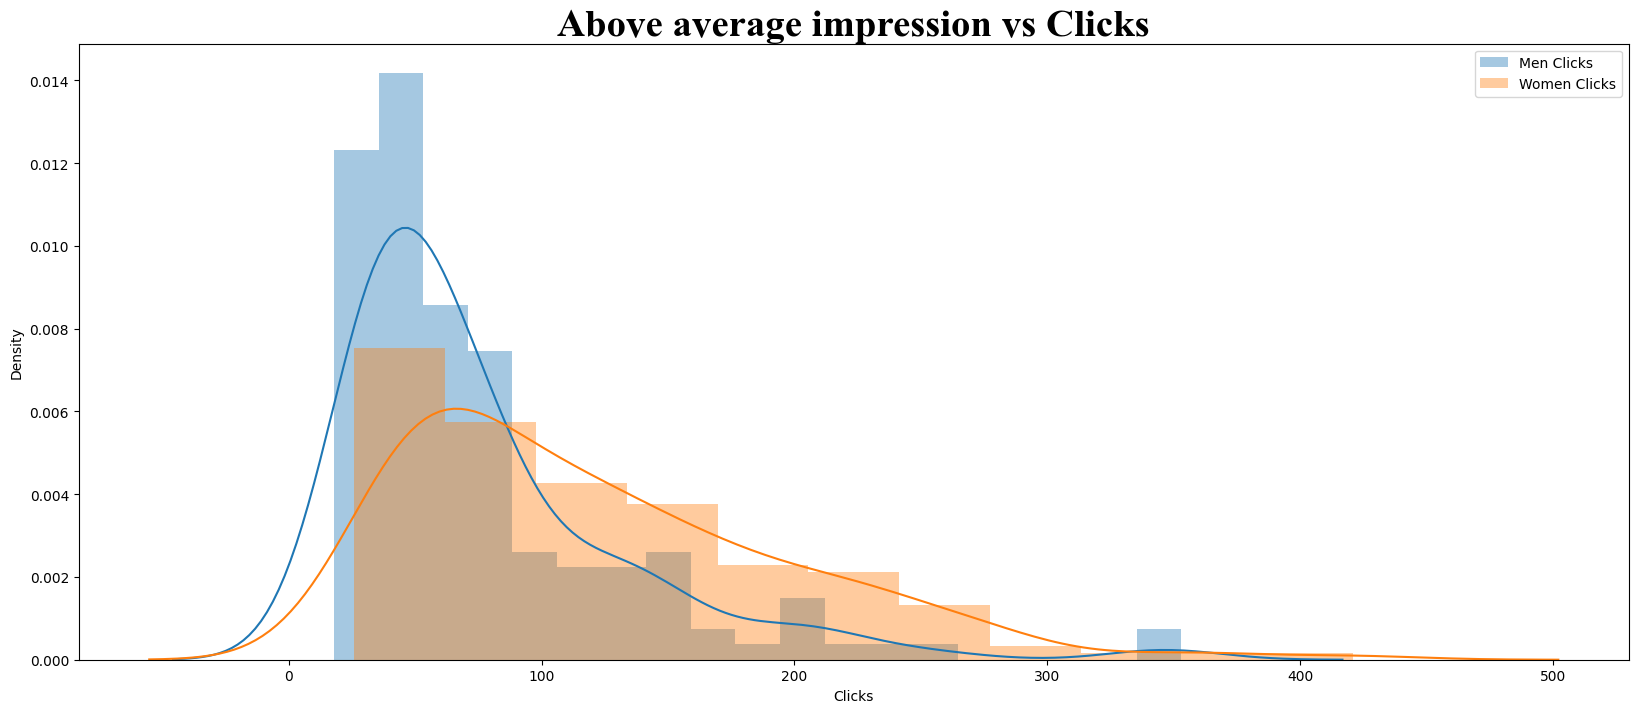

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_30792\2265318992.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(below_average_men.Clicks , label = 'Men Clicks')
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_30792\2265318992.py:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(below_average_women

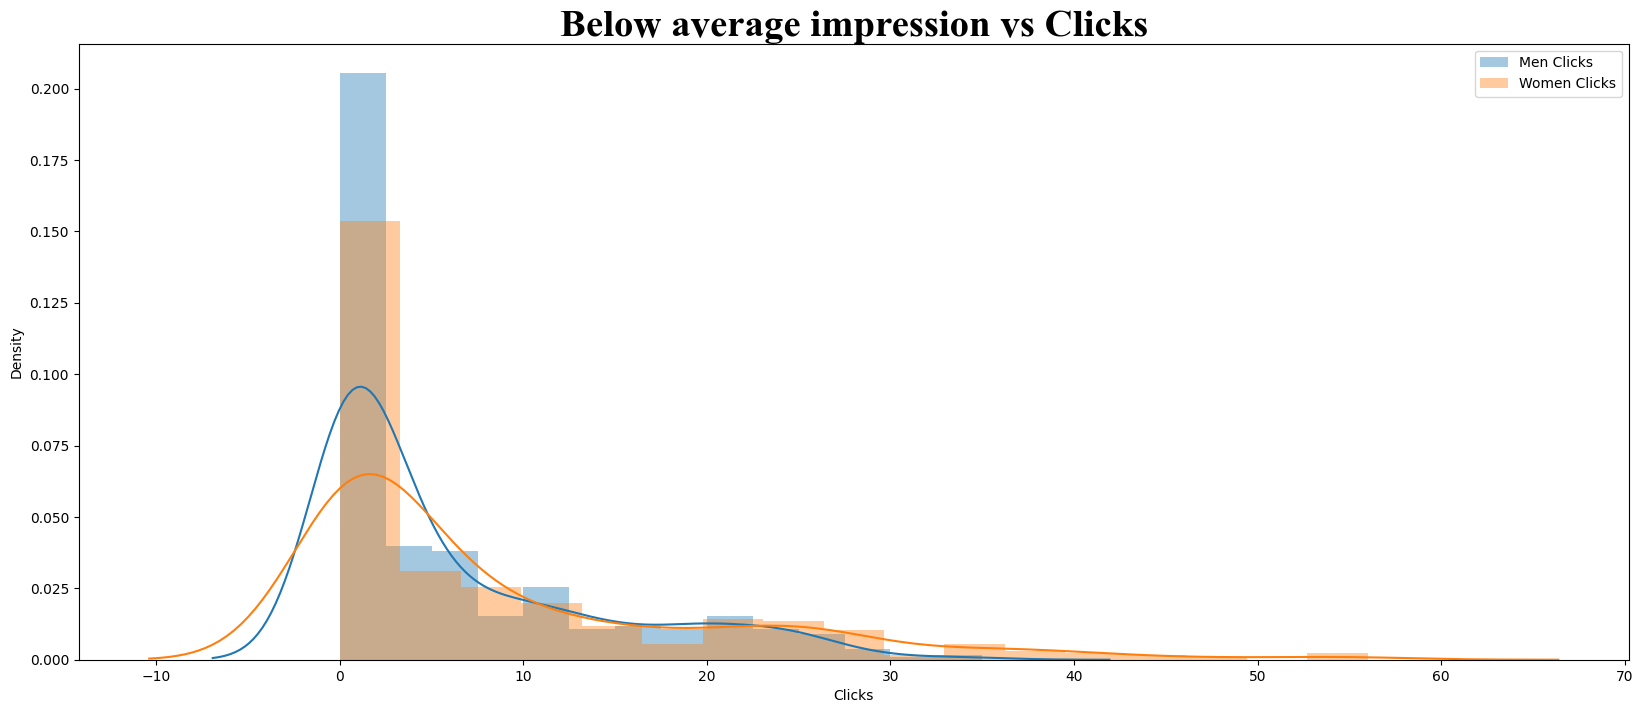

In [26]:
plt.figure(figsize = (20,8))

sns.distplot(above_average_men.Clicks , label = 'Men Clicks')
sns.distplot(above_average_women.Clicks, label = 'Women Clicks')
plt.title('Above average impression vs Clicks', fontweight="bold", fontname="Times New Roman", size=28)
plt.legend()
          
plt.show()

plt.figure(figsize = (20,8))

sns.distplot(below_average_men.Clicks , label = 'Men Clicks')
sns.distplot(below_average_women.Clicks , label = 'Women Clicks')
plt.title('Below average impression vs Clicks', fontweight="bold", fontname="Times New Roman", size=28)
plt.legend()
          
plt.show()

When women were shown ads more than the above average amount, they tend to click on it more often than men, who were shown the same amount of ads.

When women were shown ads less than the above average amount, then number of clicks fell drastically for both men and women, but women still clicked more than men did.

notice peak is shifted in more than average and on same point in below average

visualising numerical variables

In [27]:
data = df[['interest',
 'Impressions',
 'Clicks',
 'Spent',
 'Total_Conversion',
 'Approved_Conversion']]
data

,interest,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion
0,15,7350,1,1.430000,2,1
1,16,17861,2,1.820000,2,0
2,20,693,0,0.000000,1,0
3,28,4259,1,1.250000,1,0
4,28,4133,1,1.290000,1,1
...,...,...,...,...,...,...
1138,109,1129773,252,358.189997,13,2
1139,110,637549,120,173.880003,3,0
1140,111,151531,28,40.289999,2,0
1141,113,790253,135,198.710001,8,2


<Figure size 2000x800 with 0 Axes>

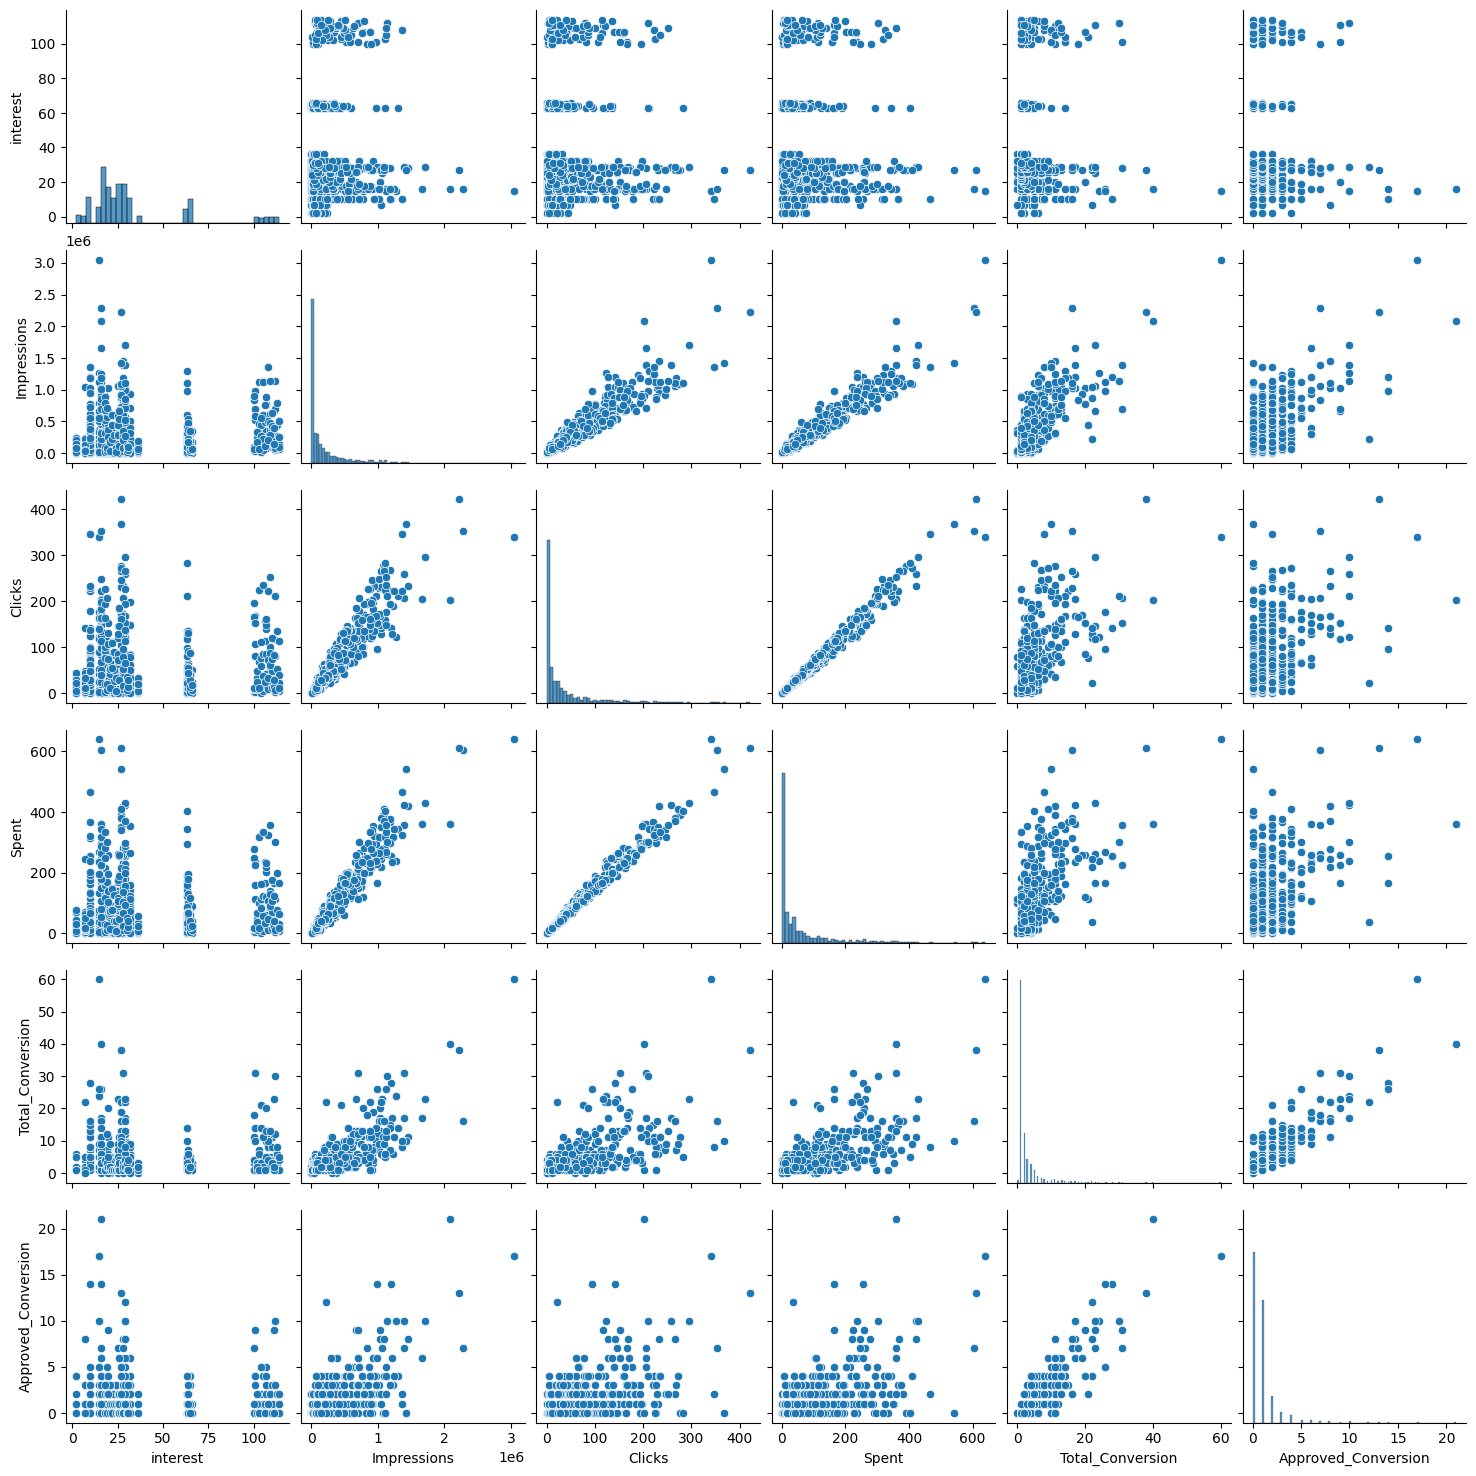

In [28]:
plt.figure(figsize = (20,8))

sns.pairplot(data)

plt.show()

inference - if consider total_conversion/approved_conversion as variable of interest
some variables are vary linearly with dependent variable(linear regression is possible)

however, click and spent is multi-collinear i.e. both provide almost same information

also , other variable look almost like clusters or classification type and others are randomly scattered

In [29]:
import plotly.express as px 
  
fig = px.scatter_3d(df, x='age', 
                    y='gender',  
                    z='interest', 
                    size='Spent',  
                    color='gender') 
fig.update_layout(
    height=1000  # Thay đổi giá trị chiều cao theo ý muốn (ví dụ: 800px)
)


fig.show()

In [31]:
file_path = '../data/raw/KAG_conversion_data.csv'
df = pd.read_csv(file_path)


In [32]:
df

,ad_id,xyz_campaign_id,fb_campaign_id,age,gender,interest,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion
0,708746,916,103916,30-34,M,15,7350,1,1.430000,2,1
1,708749,916,103917,30-34,M,16,17861,2,1.820000,2,0
2,708771,916,103920,30-34,M,20,693,0,0.000000,1,0
3,708815,916,103928,30-34,M,28,4259,1,1.250000,1,0
4,708818,916,103928,30-34,M,28,4133,1,1.290000,1,1
...,...,...,...,...,...,...,...,...,...,...,...
1138,1314410,1178,179977,45-49,F,109,1129773,252,358.189997,13,2
1139,1314411,1178,179978,45-49,F,110,637549,120,173.880003,3,0
1140,1314412,1178,179979,45-49,F,111,151531,28,40.289999,2,0
1141,1314414,1178,179981,45-49,F,113,790253,135,198.710001,8,2


In [35]:
grouped_data = df.groupby('interest')[['Spent', 'Clicks']].sum().reset_index()
grouped_data

,interest,Spent,Clicks
0,2,503.450005,311
1,7,648.929999,410
2,10,5086.379995,3317
3,15,2597.259995,1609
4,16,8084.909990,5144
5,18,2425.070001,1524
6,19,1940.359993,1188
7,20,1960.770001,1234
8,21,824.209999,512
9,22,1039.859998,717


<Figure size 2000x5000 with 0 Axes>

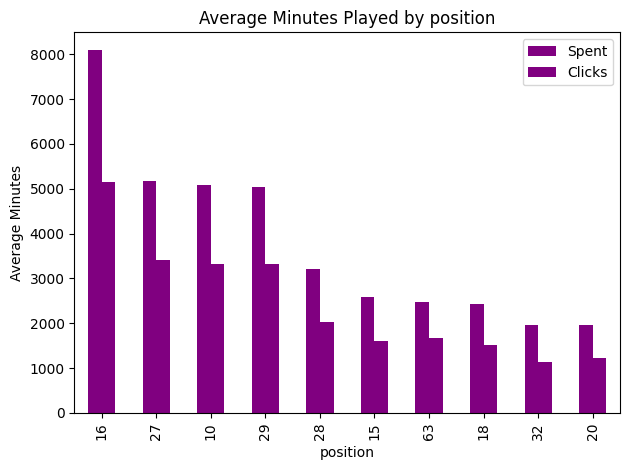

In [47]:
average_minutes = df.groupby('interest')[['Spent', 'Clicks']].sum().nlargest(10,  'Spent')
plt.figure(figsize=(20, 50))
average_minutes.plot(kind='bar', color='purple')
plt.title('Average Minutes Played by position')
plt.xlabel('position')
plt.ylabel('Average Minutes')
plt.tight_layout()
plt.show()

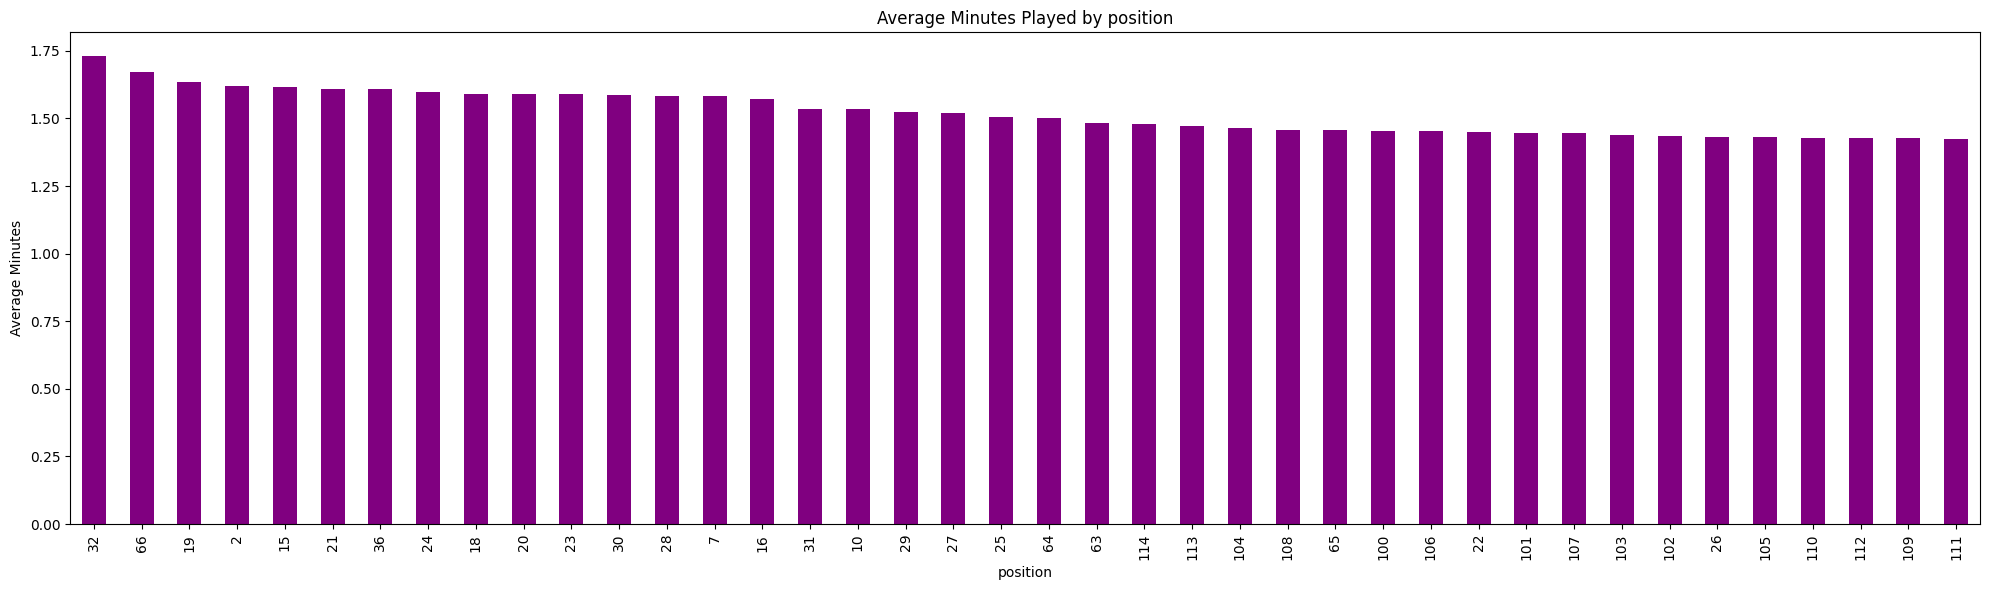

In [53]:
average_minutes = (
    df.groupby('interest')[['Spent', 'Clicks']]
    .sum()
)
average_minutes['Spent_per_Click'] = average_minutes['Spent'] / average_minutes['Clicks']
# Thêm cột Spent per Click
plt.figure(figsize=(20, 6))
average_minutes['Spent_per_Click'].sort_values(ascending=False).plot(kind='bar', color='purple')
plt.title('Average Minutes Played by position')
plt.xlabel('position')
plt.ylabel('Average Minutes')
plt.tight_layout()
plt.show()

Total_Conversion	Approved_Conversion

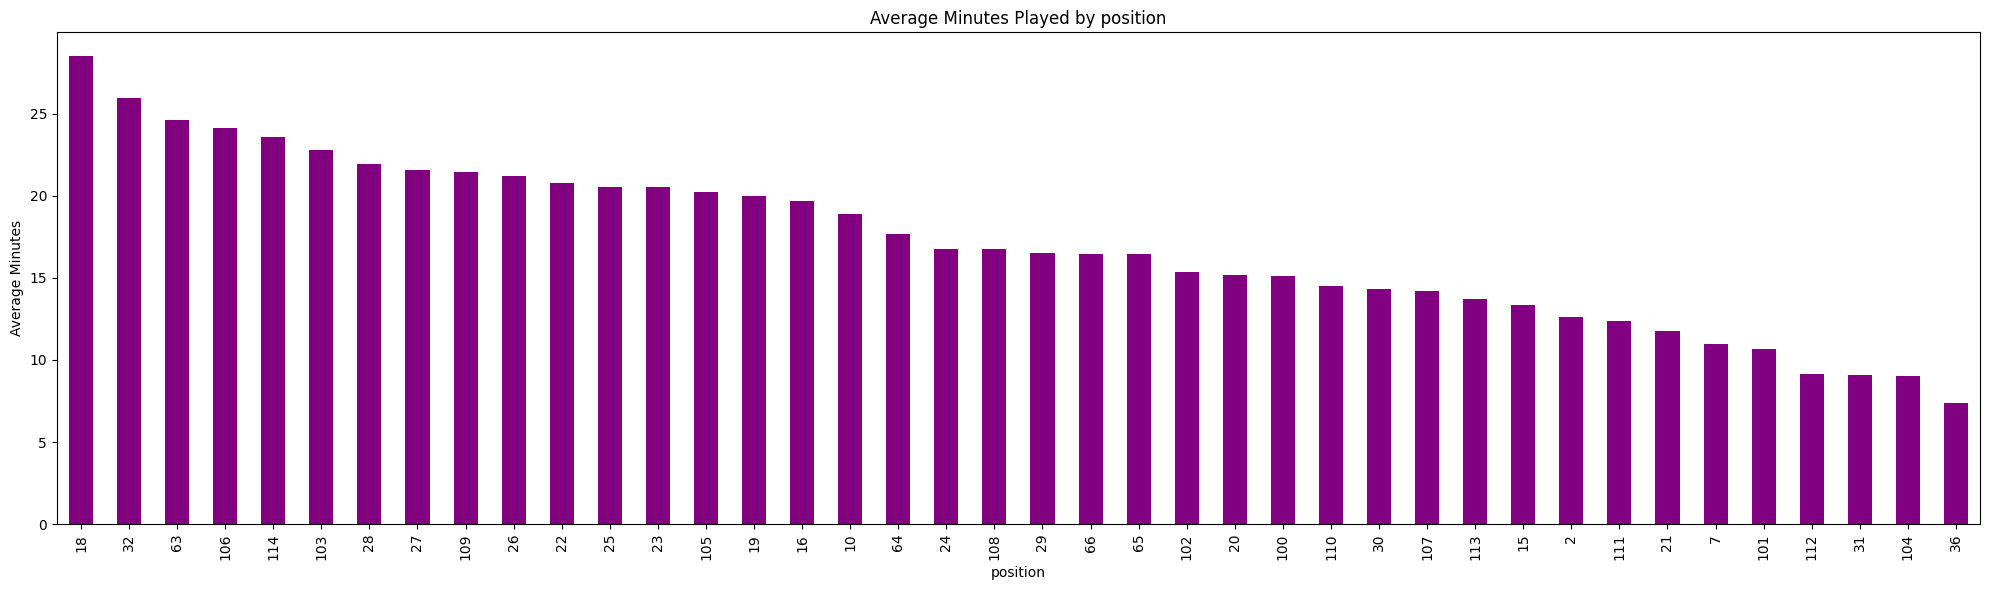

In [60]:
average_minutes = (
    df.groupby('interest')[['Spent', 'Total_Conversion']]
    .sum()
)
average_minutes['Spent_per_Click'] = average_minutes['Spent'] / average_minutes['Total_Conversion']
# Thêm cột Spent per Click
plt.figure(figsize=(20, 6))
average_minutes['Spent_per_Click'].sort_values(ascending=False).plot(kind='bar', color='purple')
plt.title('Average Minutes Played by position')
plt.xlabel('position')
plt.ylabel('Average Minutes')
plt.tight_layout()
plt.show()


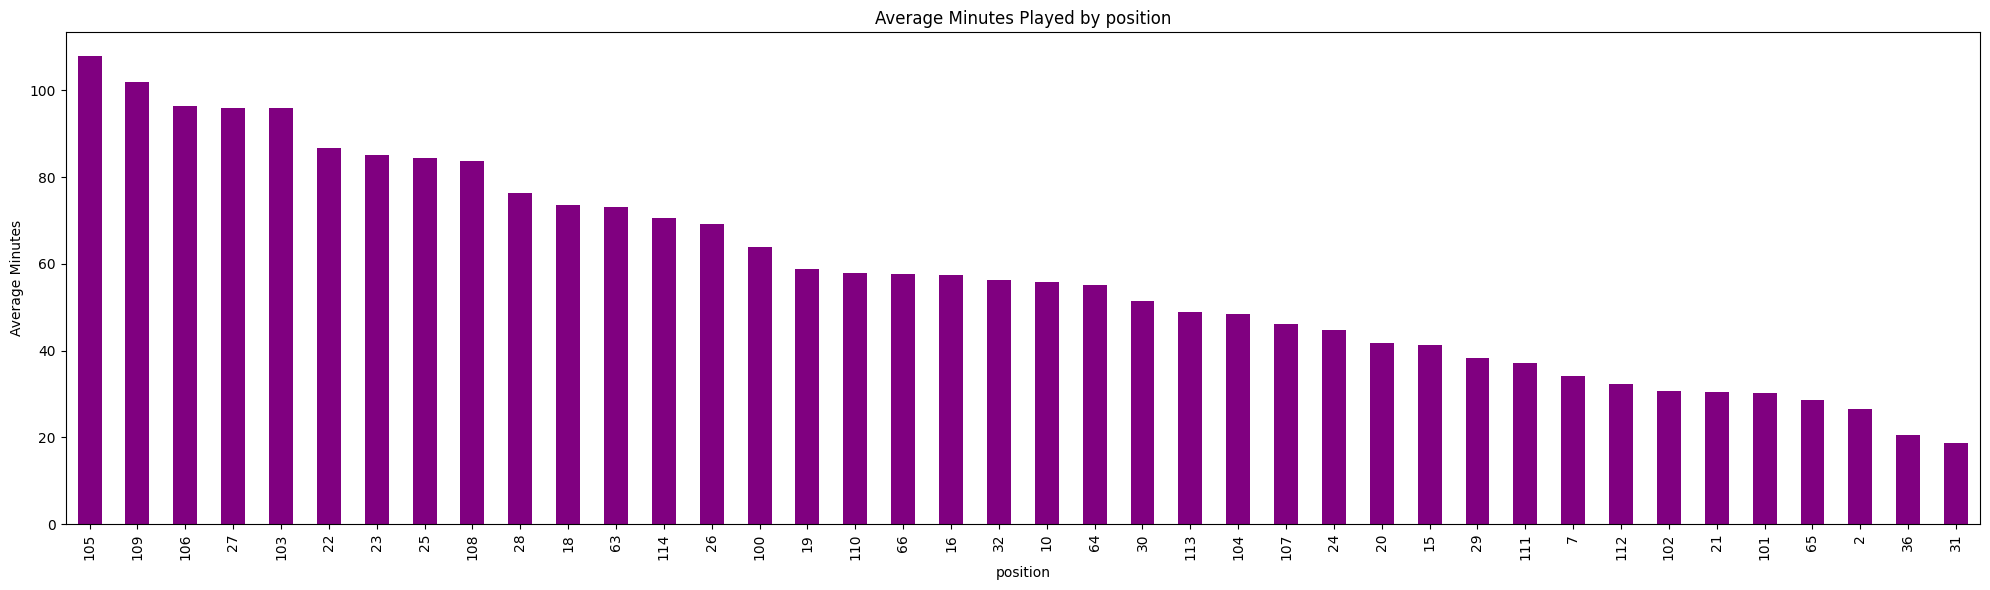

In [59]:
average_minutes = (
    df.groupby('interest')[['Spent', 'Approved_Conversion']]
    .sum()
)
average_minutes['Spent_per_Click'] = average_minutes['Spent'] / average_minutes['Approved_Conversion']
# Thêm cột Spent per Click
plt.figure(figsize=(20, 6))
average_minutes['Spent_per_Click'].sort_values(ascending=False).plot(kind='bar', color='purple')
plt.title('Average Minutes Played by position')
plt.xlabel('position')
plt.ylabel('Average Minutes')
plt.tight_layout()
plt.show()


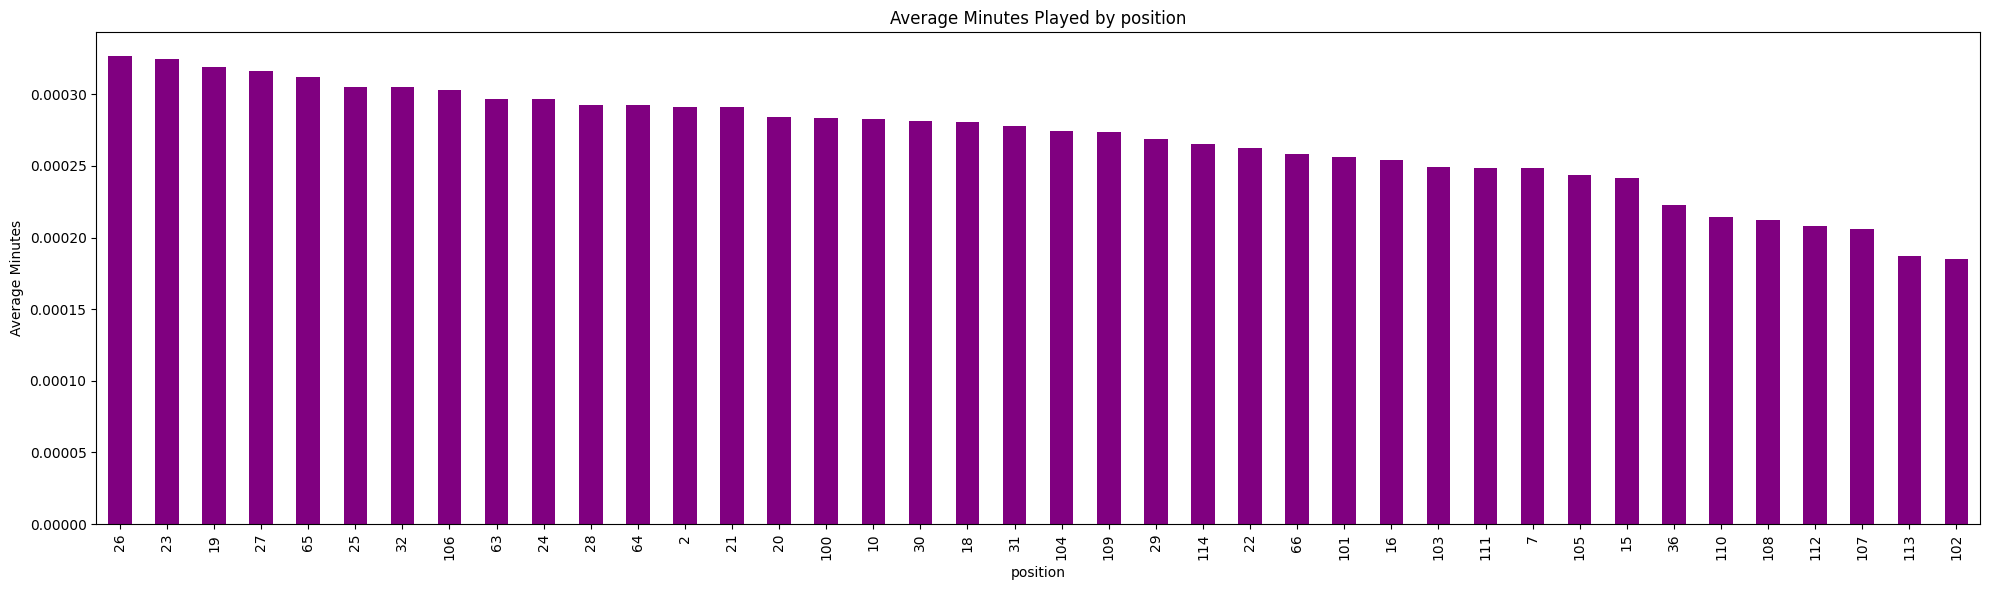

In [56]:
average_minutes = (
    df.groupby('interest')[['Spent', 'Impressions']]
    .sum()
)
average_minutes['Spent_per_Click'] = average_minutes['Spent'] / average_minutes['Impressions']
# Thêm cột Spent per Click
plt.figure(figsize=(20, 6))
average_minutes['Spent_per_Click'].sort_values(ascending=False).plot(kind='bar', color='purple')
plt.title('Average Minutes Played by position')
plt.xlabel('position')
plt.ylabel('Average Minutes')
plt.tight_layout()
plt.show()

<Figure size 2000x5000 with 0 Axes>

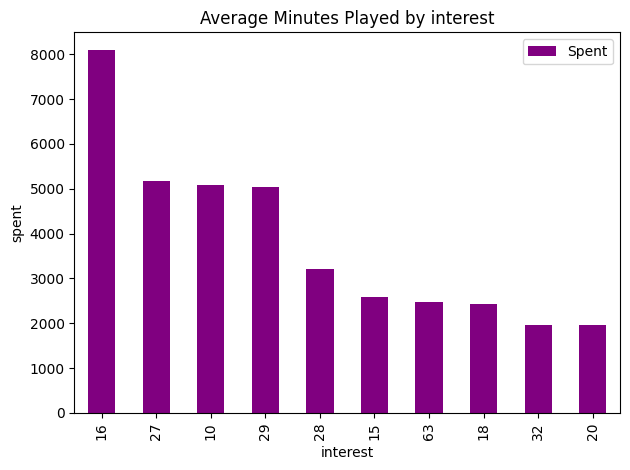

In [63]:
average_minutes = df.groupby('interest')[['Spent']].sum().nlargest(10,  'Spent')
plt.figure(figsize=(20, 50))
average_minutes.plot(kind='bar', color='purple')
plt.title('Average Minutes Played by interest')
plt.xlabel('interest')
plt.ylabel('spent')
plt.tight_layout()
plt.show()

<Figure size 2000x5000 with 0 Axes>

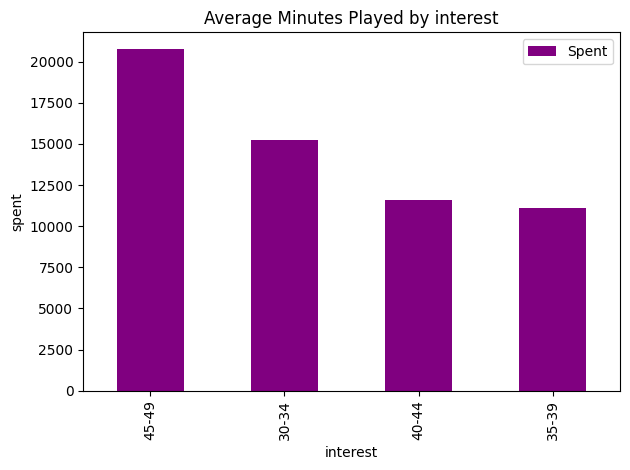

In [67]:
average_minutes = df.groupby('age')[['Spent']].sum().nlargest(10,  'Spent')
plt.figure(figsize=(20, 50))
average_minutes.plot(kind='bar', color='purple')
plt.title('Average Minutes Played by interest')
plt.xlabel('interest')
plt.ylabel('spent')
plt.tight_layout()
plt.show()

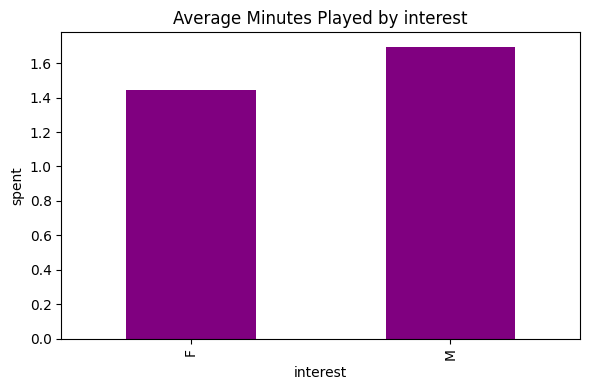

In [77]:
average_minutes = df.groupby('gender')[['Spent', 'Clicks']].sum()
average_minutes['a'] = average_minutes['Spent'] / average_minutes['Clicks'] 

plt.figure(figsize=(6, 4))
average_minutes['a'].plot(kind='bar', color='purple')
plt.title('Average Minutes Played by interest')
plt.xlabel('interest')
plt.ylabel('spent')
plt.tight_layout()
plt.show()

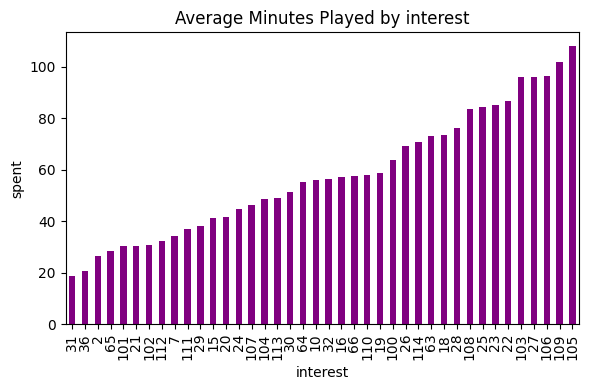

In [85]:
average_minutes = df.groupby('interest')[['Spent', 'Approved_Conversion']].sum()
average_minutes['a'] = average_minutes['Spent'] / average_minutes['Approved_Conversion']

plt.figure(figsize=(6, 4))
average_minutes['a'].sort_values(ascending=True).plot(kind='bar', color='purple')
plt.title('Average Minutes Played by interest')
plt.xlabel('interest')
plt.ylabel('spent')
plt.tight_layout()
plt.show()


# => Tỷ lệ chuyển đổi sang click và impression khá ổn nhưng tỷ lên chuyển sang conversion thì ko ổn lắm
# Impressions	Clicks	Spent	Total_Conversion	Approved_Conversio

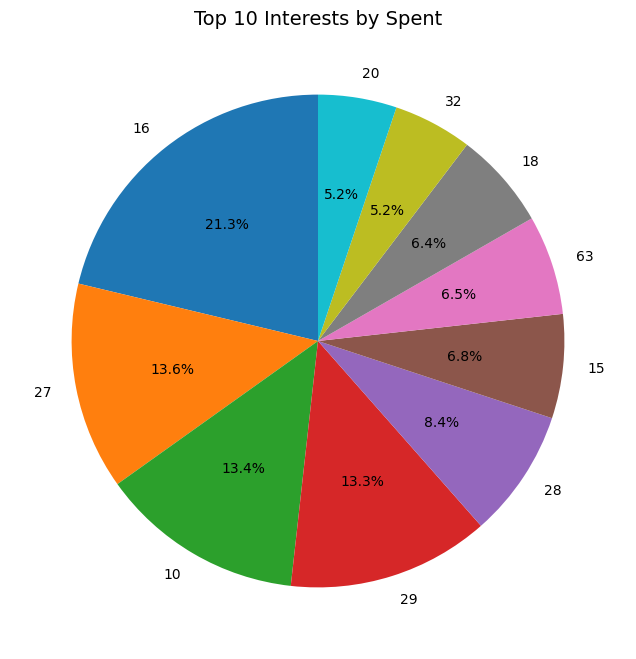

In [92]:

top_interests = df.groupby('interest')[['Spent']].sum().nlargest(10, columns="Spent")


plt.figure(figsize=(8, 8))
plt.pie(
    top_interests['Spent'],
    labels=top_interests.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=plt.cm.tab10.colors
)
plt.title('Top 10 Interests by Spent', fontsize=14)
plt.show()


In [94]:
# Nhóm dữ liệu theo cột 'age' và tính các chỉ số
result = df.groupby('age').agg(
    Conversion_Rate_Spent_Total=('Total_Conversion', lambda x: x.sum() / df.loc[x.index, 'Spent'].sum()),
    Avg_Approve_Conversion=('Approved_Conversion', 'mean')
).reset_index()

# Hiển thị kết quả
print(result)


     age  Conversion_Rate_Spent_Total  Avg_Approve_Conversion
0  30-34                     0.093821                1.159624
1  35-39                     0.056333                0.834677
2  40-44                     0.045126                0.809524
3  45-49                     0.032963                0.803089


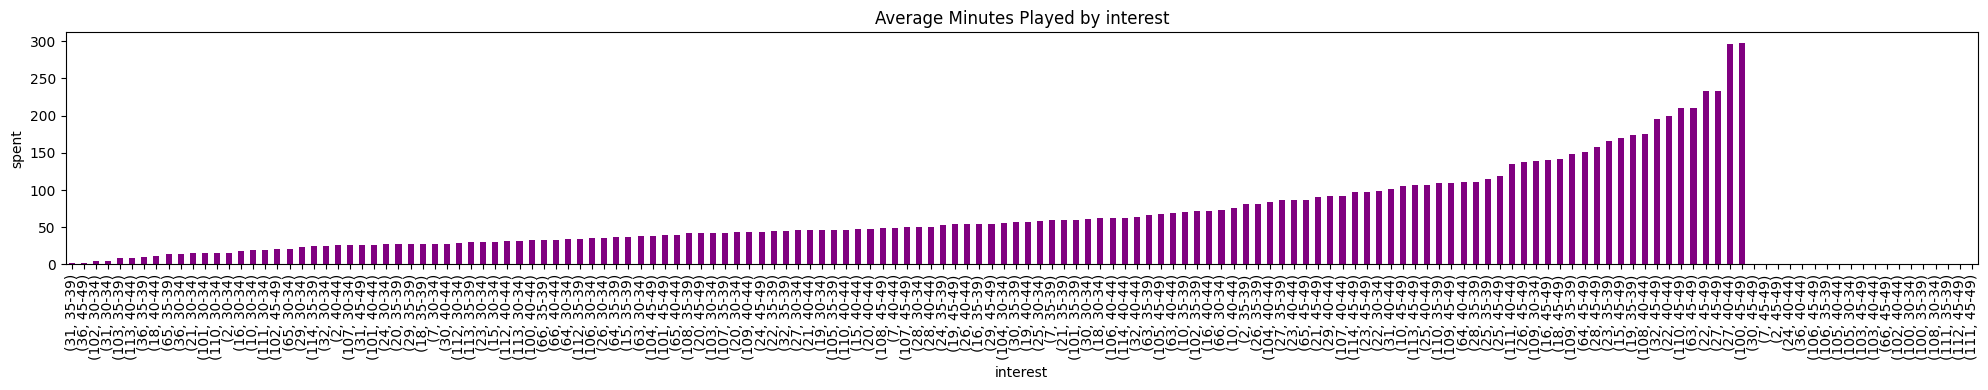

In [98]:
average_minutes = df.groupby(['interest', 'age'])[['Spent', 'Approved_Conversion']].sum()
average_minutes['a'] = average_minutes['Spent'] / average_minutes['Approved_Conversion']

plt.figure(figsize=(20, 4))
average_minutes['a'].sort_values(ascending=True).plot(kind='bar', color='purple')
plt.title('Average Minutes Played by interest')
plt.xlabel('interest')
plt.ylabel('spent')
plt.tight_layout()
plt.show()


# => Tỷ lệ chuyển đổi sang click và impression khá ổn nhưng tỷ lên chuyển sang conversion thì ko ổn lắm
# Impressions	Clicks	Spent	Total_Conversion	Approved_Conversio

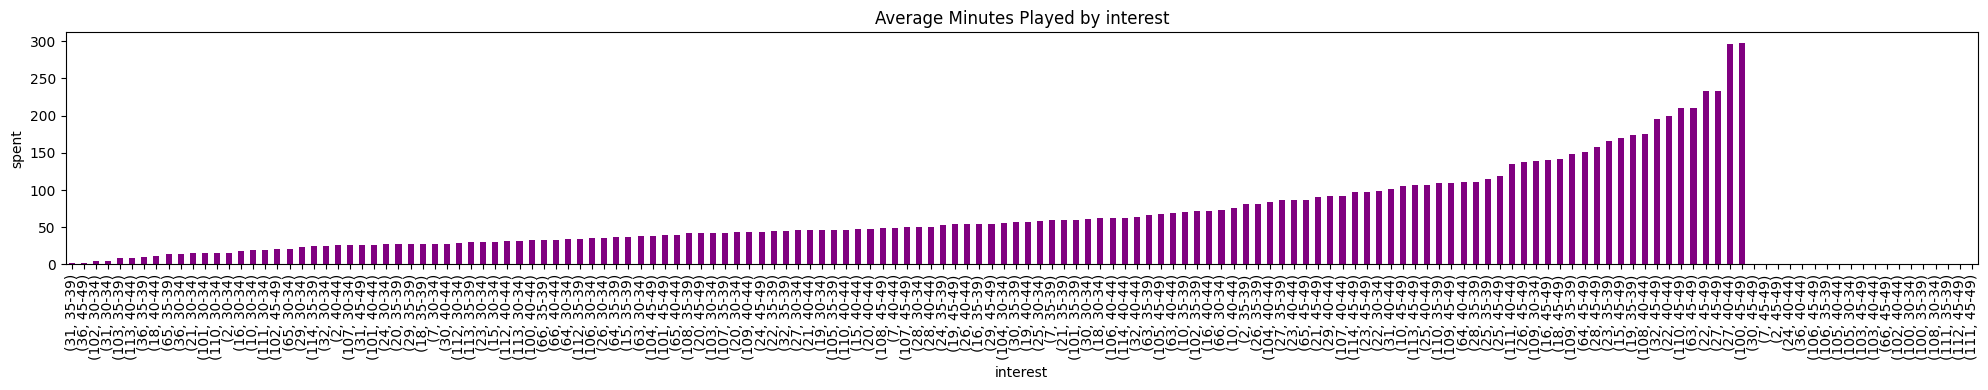

In [99]:
average_minutes = df.groupby(['interest', 'age'])[['Spent', 'Approved_Conversion']].sum()
average_minutes['a'] = average_minutes['Spent'] / average_minutes['Approved_Conversion']

plt.figure(figsize=(20, 4))
average_minutes['a'].sort_values(ascending=True).plot(kind='bar', color='purple')
plt.title('Average Minutes Played by interest')
plt.xlabel('interest')
plt.ylabel('spent')
plt.tight_layout()
plt.show()


# => Tỷ lệ chuyển đổi sang click và impression khá ổn nhưng tỷ lên chuyển sang conversion thì ko ổn lắm
# Impressions	Clicks	Spent	Total_Conversion	Approved_Conversio

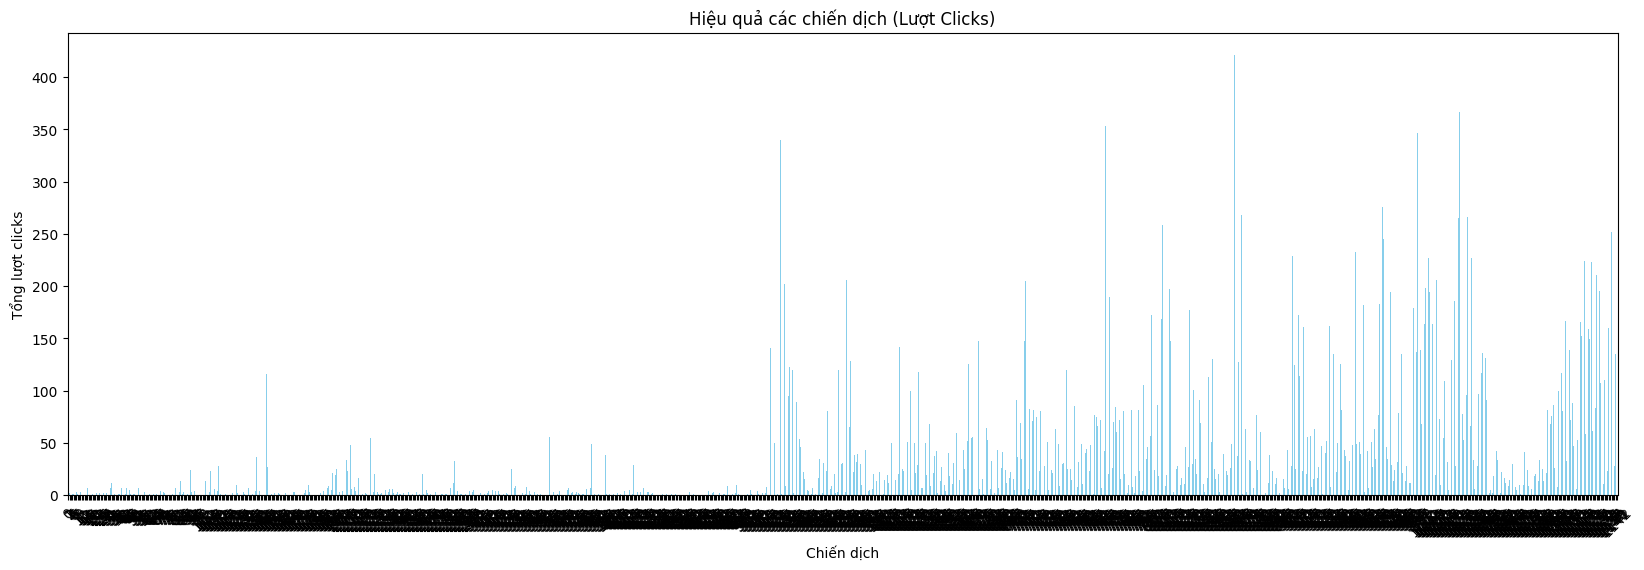

In [109]:
plt.figure(figsize=(20, 6))
df['Clicks'].plot(kind='bar', color='skyblue')
plt.title('Hiệu quả các chiến dịch (Lượt Clicks)')
plt.xlabel('Chiến dịch')
plt.ylabel('Tổng lượt clicks')
plt.xticks(rotation=45)
plt.show()

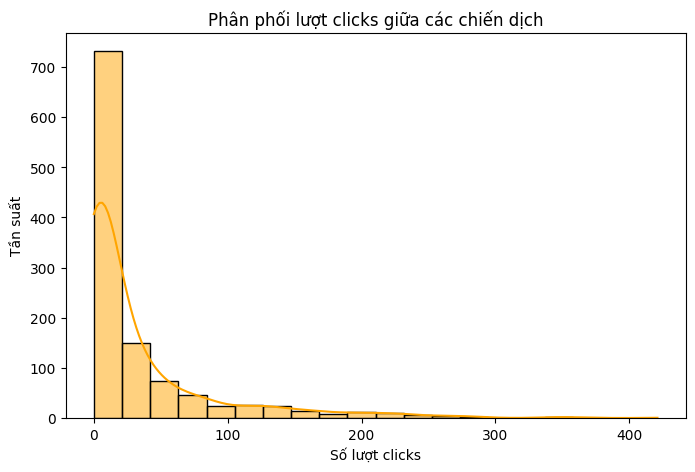

In [111]:
plt.figure(figsize=(8, 5))
sns.histplot(df['Clicks'], kde=True, bins=20, color='orange')
plt.title('Phân phối lượt clicks giữa các chiến dịch')
plt.xlabel('Số lượt clicks')
plt.ylabel('Tần suất')
plt.show()

Text(0.5, 1.0, 'Age Distribution')

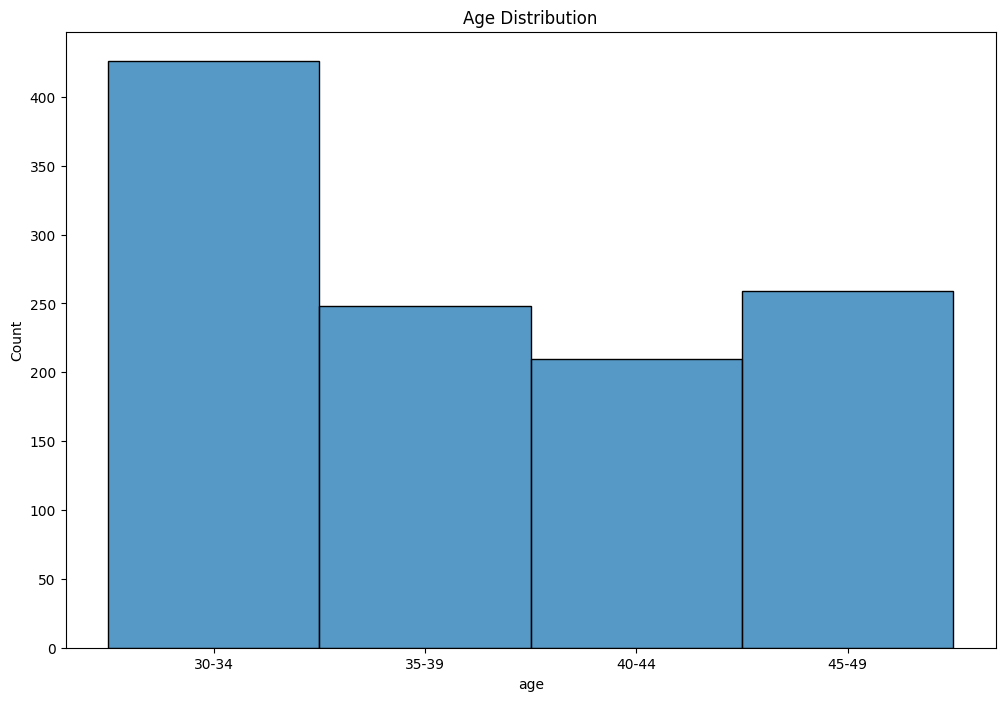

In [115]:
plt.figure(figsize=(12,8))
sns.histplot(df['age'])
plt.title('Age Distribution')

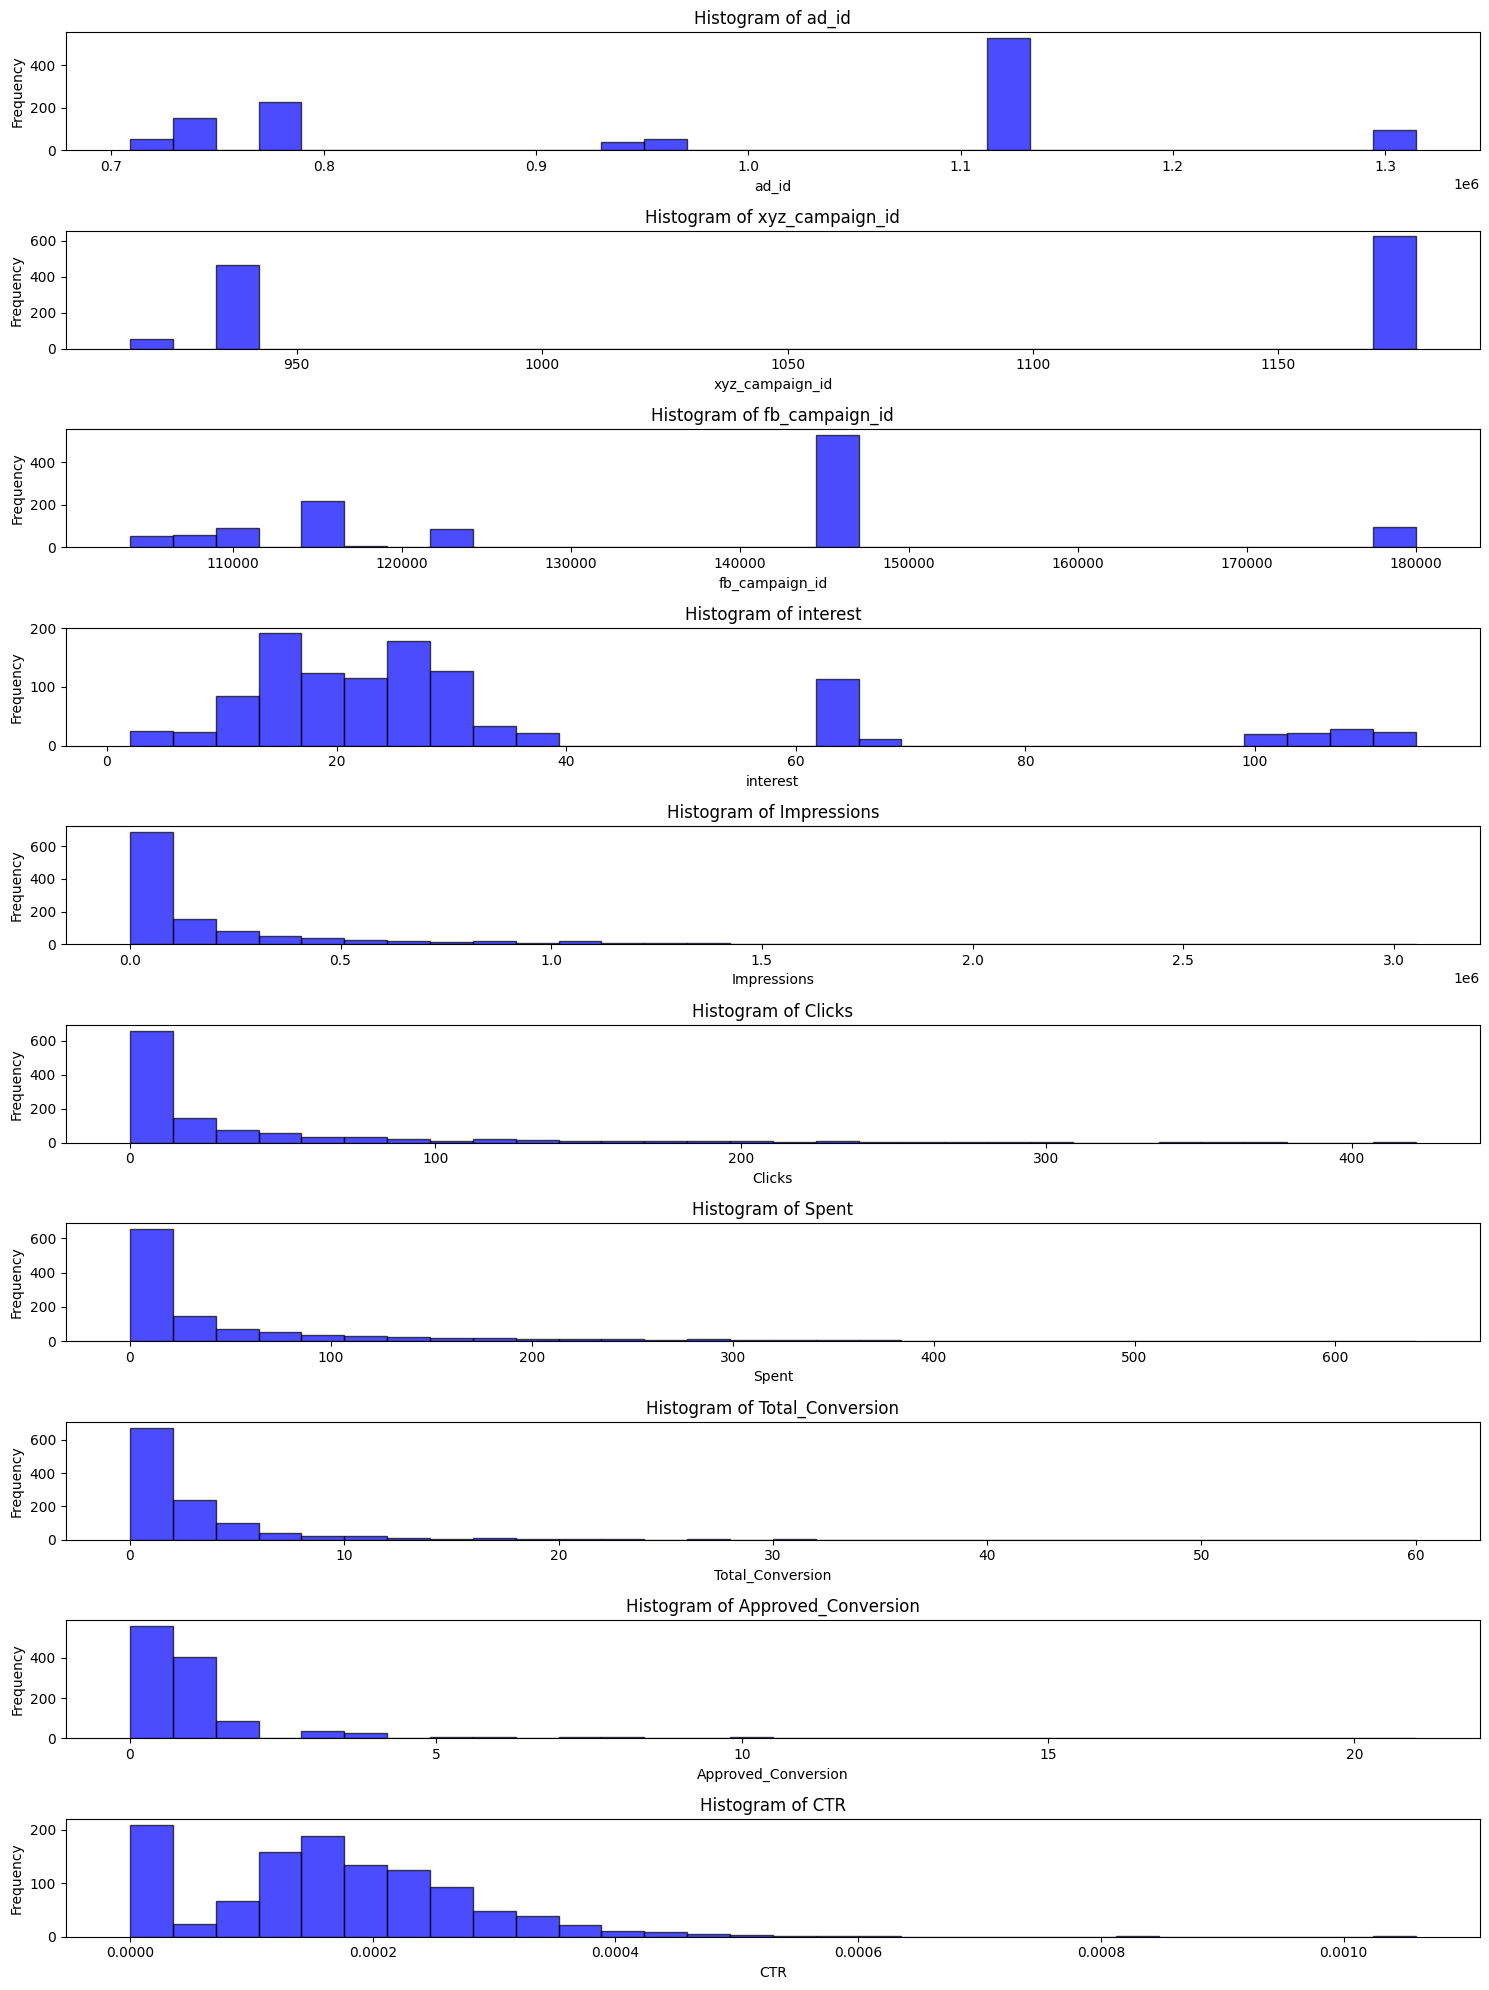

In [118]:
numeric_columns = df.select_dtypes(include=['number']).columns

# Tạo biểu đồ histogram
plt.figure(figsize=(15, 20))  # Điều chỉnh kích thước của biểu đồ
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(len(numeric_columns), 1, i)
    plt.hist(df[col].dropna(), bins=30, alpha=0.7, color='blue', edgecolor='black')
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.tight_layout()  # Điều chỉnh khoảng cách giữa các biểu đồ

plt.show()


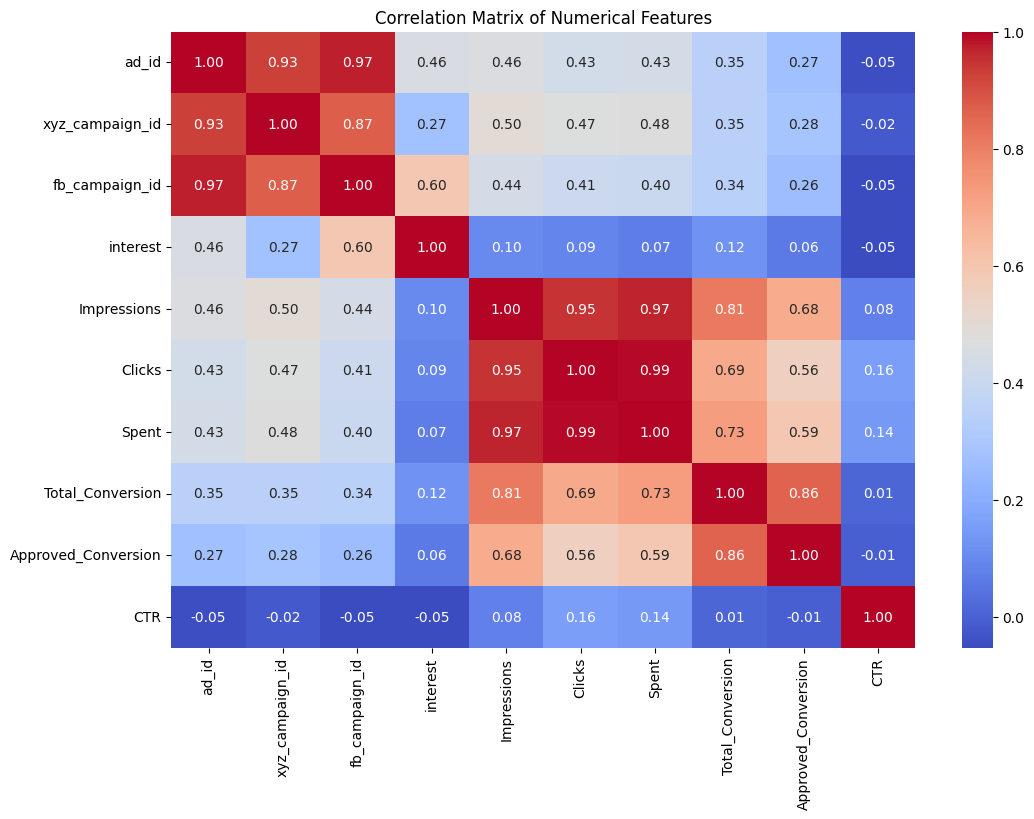

In [121]:
numeric_columns = df.select_dtypes(include=['number'])

# Tính toán ma trận tương quan
correlation_matrix = numeric_columns.corr()

# Vẽ heatmap cho ma trận tương quan
plt.figure(figsize=(12, 8))  # Điều chỉnh kích thước biểu đồ
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)

plt.title("Correlation Matrix of Numerical Features")
plt.show()